Remember to run "pyspark --jar /PATH/"

# Making Prediction with Spark-ts (Spark time-series) Library

- Performing time-series analysis and crime occurence prediction with the sparkts library

In [18]:
#%matplotlib notebook

from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark import SparkContext
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sparkts.models import ARIMA

In [3]:
sqlContext = SQLContext(sc)

Loading the dataset

In [4]:
dataPath ='../ts-test/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv'

crimeDataSchema = StructType([StructField("IncidntNum", LongType(), True),
                              StructField("Category", StringType(), True),
                              StructField("Descript", StringType(), True),
                              StructField("DayOfWeek", StringType(), True),
                              StructField("Date", StringType(), True),
                              StructField("Time", StringType(), True),
                              StructField("PdDistrict", StringType(), True),
                              StructField("Resolution", StringType(), True),
                              StructField("Address", StringType(), True),
                              StructField("X", DoubleType(), True),
                              StructField("Y", DoubleType(), True),
                              StructField("Location", StringType(), True),
                              StructField("PdId", LongType(), True)])

crimeDF = (sqlContext.read
           .format('csv')
           .option('delimiter', ',')
           .option('header', 'true')
           .load(dataPath, schema=crimeDataSchema))

In [5]:
from pyspark.sql.functions import udf, unix_timestamp, to_timestamp
import datetime


def parseDate(dateStr):
    return unix_timestamp(dateStr, 'MM/dd/yyyy').cast('timestamp')

crimeDF_date = (crimeDF.withColumn("Date_tmp", unix_timestamp(crimeDF.Date, 'MM/dd/yyyy').cast('timestamp')) #.withColumn("Date_tmp", udf(parseDate, TimestampType())(crimeDF.Date))
         .drop("Date")
         .withColumnRenamed("Date_tmp", "Date"))

In [6]:
crime_date_count = crimeDF_date.groupBy("Date", "Category").count().select("Date","Category", "Count").orderBy("Date")

In [7]:
def intCount(c):
    return float(c)

crime_date_count = (crime_date_count.withColumn("Count_t", udf(intCount, DoubleType())(crime_date_count.Count))
                                   .drop("Count")
                                   .withColumnRenamed("Count_t", "Count")
                                   .cache())

The dataframe was reconstructed to have "Date" in timestamp format and "Count" in Double type

In [8]:
crime_date_count.show()

+-------------------+--------------------+-----+
|               Date|            Category|Count|
+-------------------+--------------------+-----+
|2003-01-01 00:00:00|             ROBBERY| 10.0|
|2003-01-01 00:00:00|SEX OFFENSES, NON...|  1.0|
|2003-01-01 00:00:00|             ASSAULT| 96.0|
|2003-01-01 00:00:00|               FRAUD| 23.0|
|2003-01-01 00:00:00|FORGERY/COUNTERFE...| 16.0|
|2003-01-01 00:00:00|        PROSTITUTION|  6.0|
|2003-01-01 00:00:00|SEX OFFENSES, FOR...| 13.0|
|2003-01-01 00:00:00|        NON-CRIMINAL| 65.0|
|2003-01-01 00:00:00|           EXTORTION|  1.0|
|2003-01-01 00:00:00|           VANDALISM| 28.0|
|2003-01-01 00:00:00|               ARSON|  1.0|
|2003-01-01 00:00:00|             RUNAWAY|  1.0|
|2003-01-01 00:00:00|       LARCENY/THEFT| 72.0|
|2003-01-01 00:00:00|  DISORDERLY CONDUCT|  3.0|
|2003-01-01 00:00:00|      OTHER OFFENSES| 91.0|
|2003-01-01 00:00:00|           LOITERING|  1.0|
|2003-01-01 00:00:00|      SUSPICIOUS OCC| 35.0|
|2003-01-01 00:00:00

In [9]:
list_of_cats = [r.Category for r in crime_date_count.select("Category").distinct().collect()]

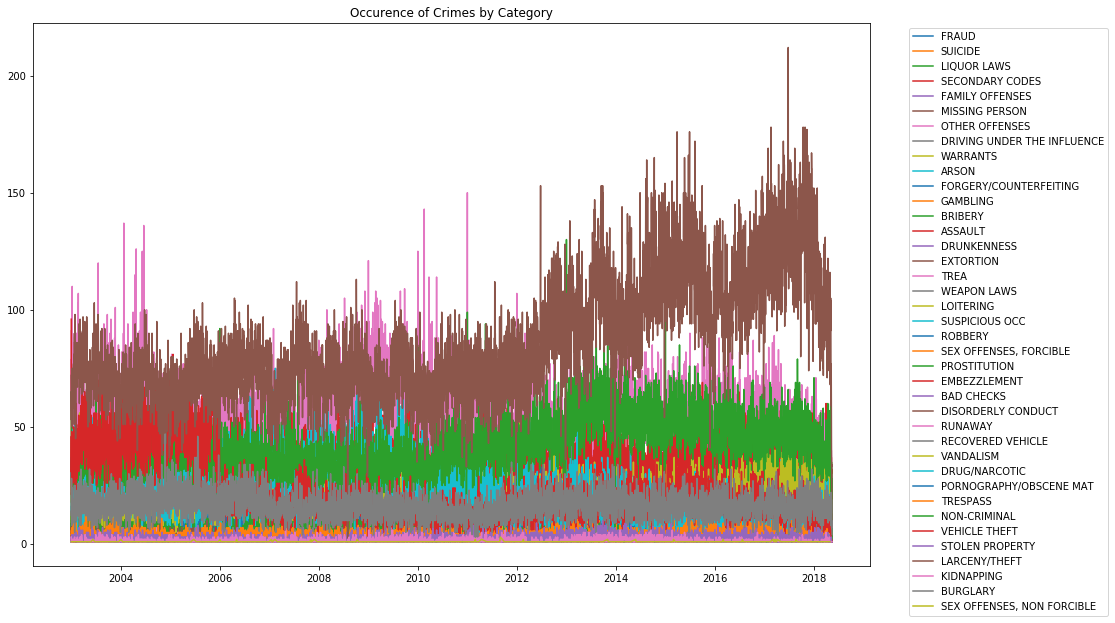

In [128]:
plt.figure(figsize=[15,10])

plt.title('Occurence of Crimes by Category')

for cat in list_of_cats:
    data = crime_date_count.where(crime_date_count["Category"] == cat).select("Date", "Count")
    dates_c = [d.Date for d in data.select("Date").collect()]
    counts_c = [r.Count for r in data.select("Count").collect()]
    plt.plot(dates_c, counts_c, label=cat)

plt.legend(loc='upper left',bbox_to_anchor=(1.04,1))
plt.show()

In [11]:
dates = crime_date_count.select("Date").collect()
dates = [d.Date for d in dates]

In [25]:
minDate = dates[0]
maxDate = dates[len(dates) - 1]

Divide the data to one from the earliest date to 2018/3/31 and one from 2018/4/1 to 2018/4/30
- The first set is used to fit the model
- The second set is used to check the prediction result

In [97]:
crime_date_count_sample = crime_date_count.where(crime_date_count.Date.between(minDate, datetime.datetime(2018, 3, 31, 0, 0))).cache()
crime_date_count_sample_future = crime_date_count.where(crime_date_count.Date.between(datetime.datetime(2018, 4, 1, 0, 0), datetime.datetime(2018, 4, 30, 0, 0))).cache()


In [107]:
from sparkts import datetimeindex

dtIdx = datetimeindex.uniform(start=minDate, end=datetime.datetime(2018, 3, 31, 0, 0), freq= datetimeindex.DayFrequency(1,sc), sc=sc)

In [108]:
from sparkts import timeseriesrdd

tsRDD = timeseriesrdd.time_series_rdd_from_observations(dtIdx, crime_date_count_sample, "Date", "Category", "Count")

In [109]:
tsRDD.cache()

MapPartitionsRDD[954] at map at NativeMethodAccessorImpl.java:0

In [110]:
tsRDD.count()

39

In [111]:
tsRDD = tsRDD.map_series(lambda x : (x[0], np.nan_to_num(x[1])))

In [112]:
ts_list = tsRDD.collect()

### Fitting ARIMA (Autoregressive, Integrated and Moving Average) Model

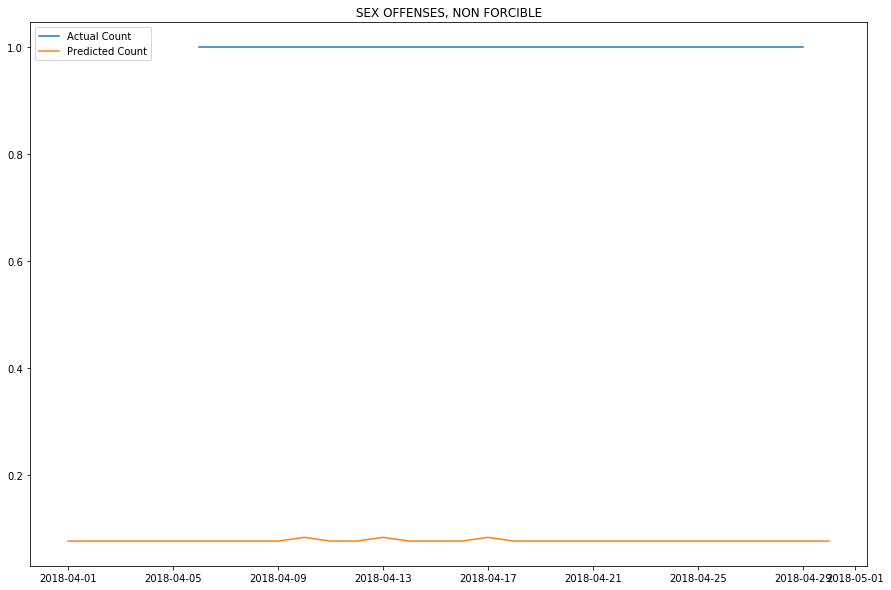

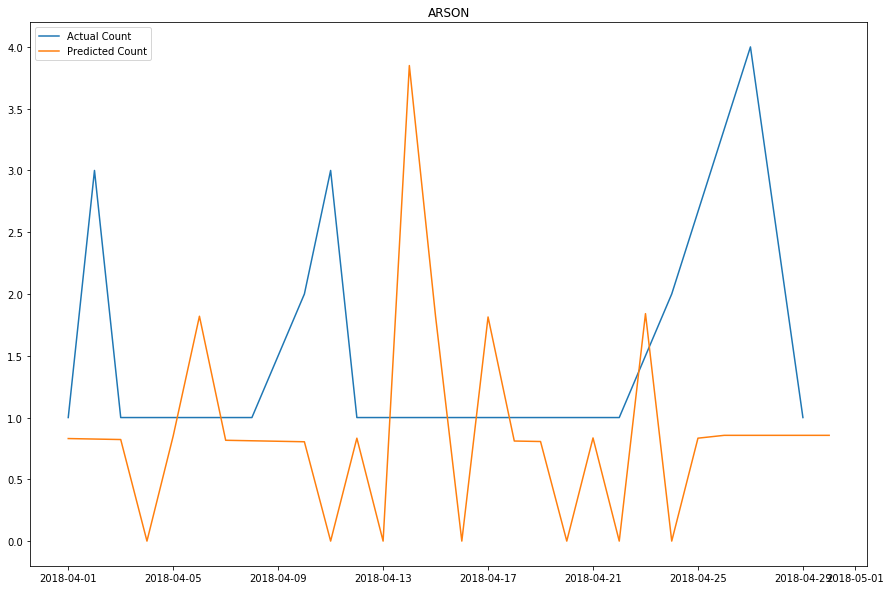

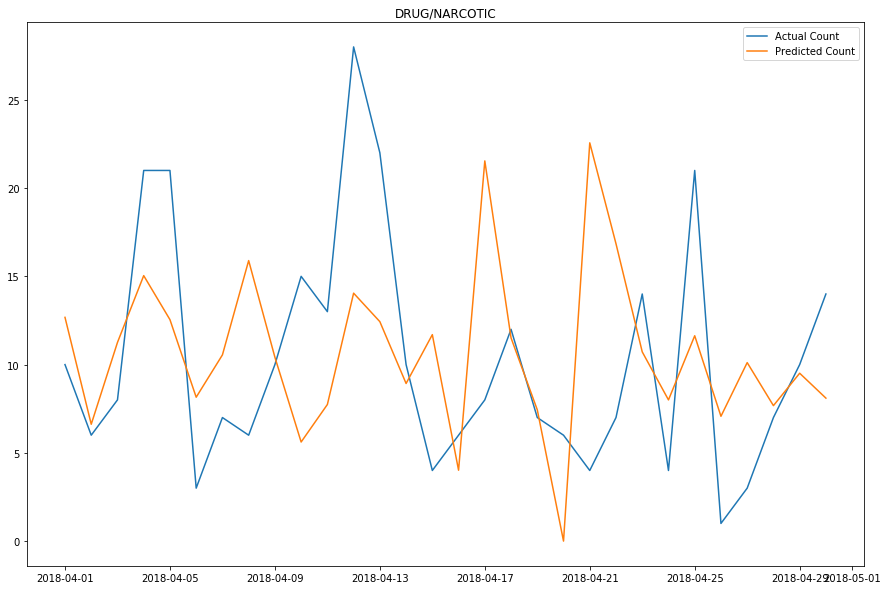

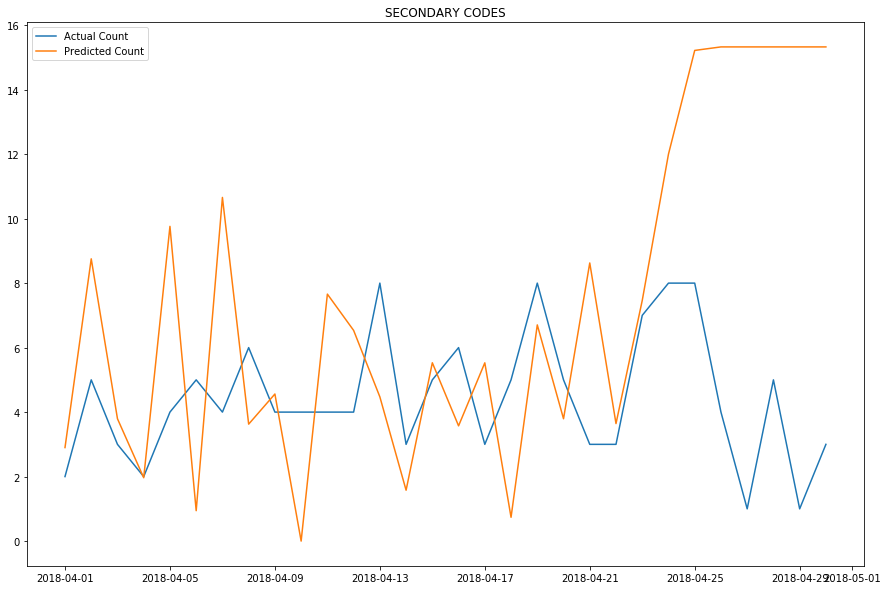

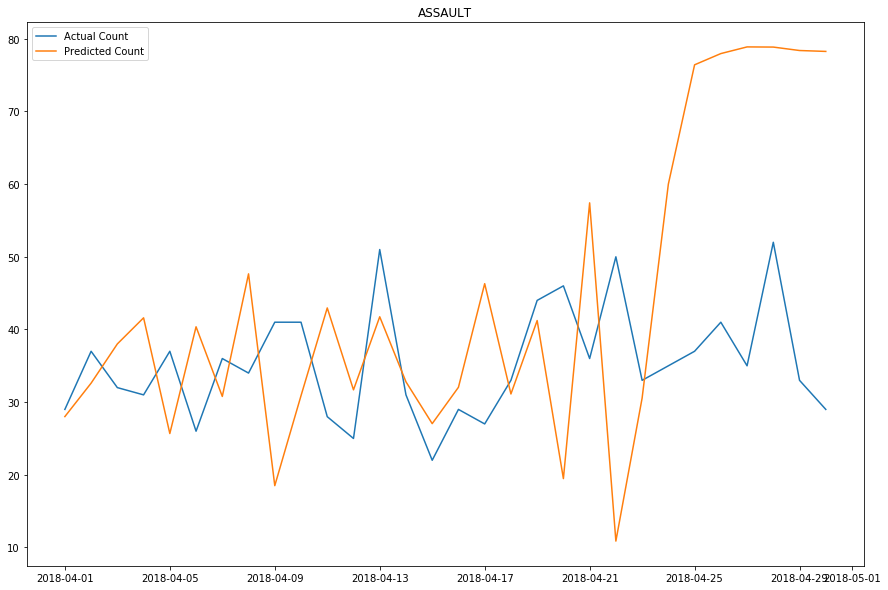

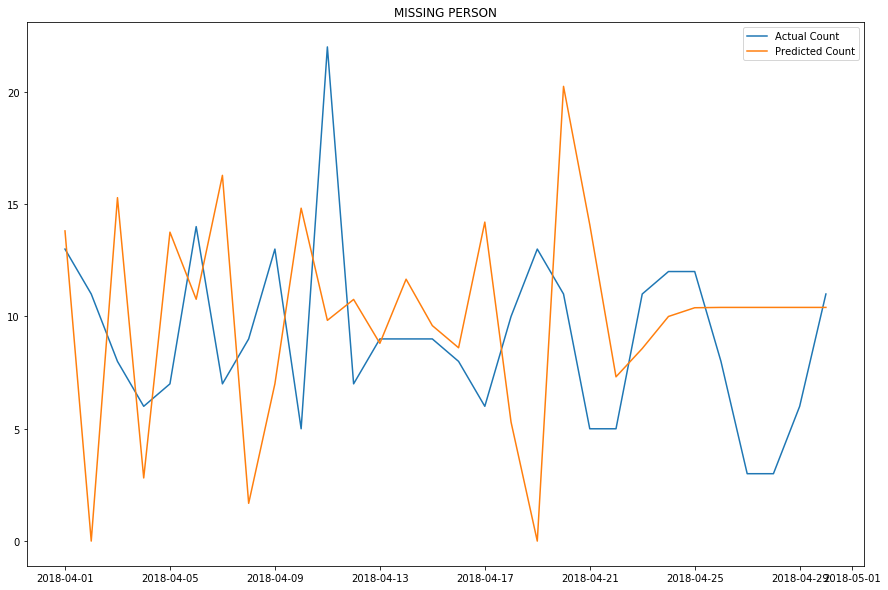

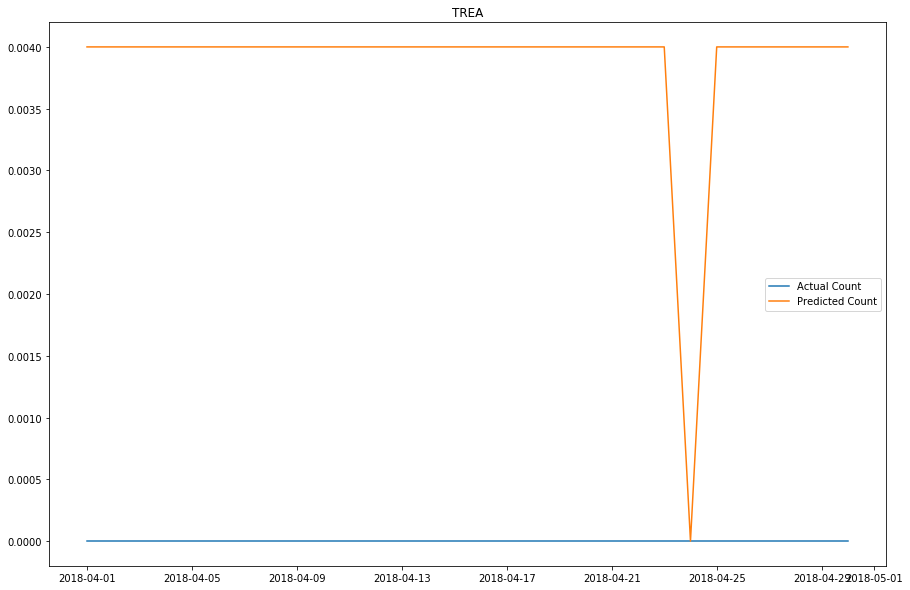

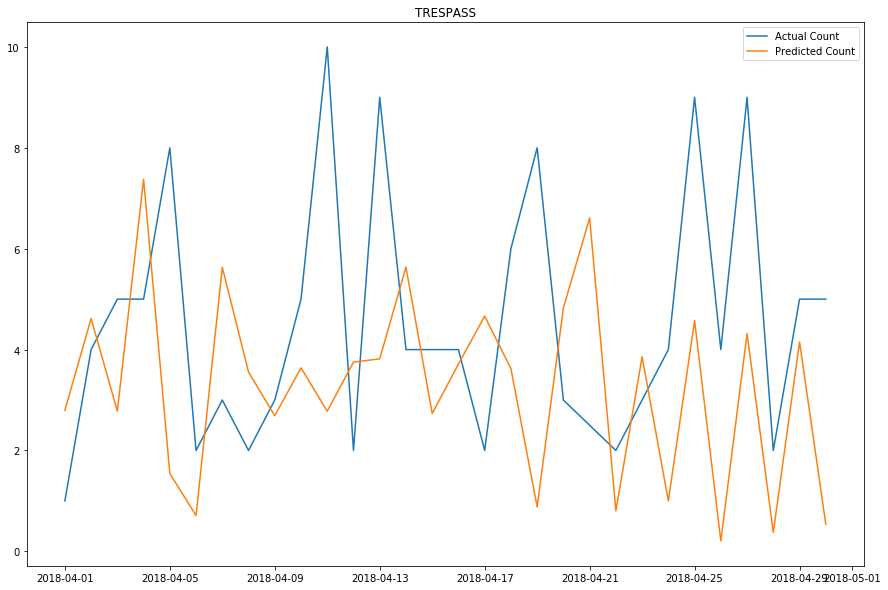

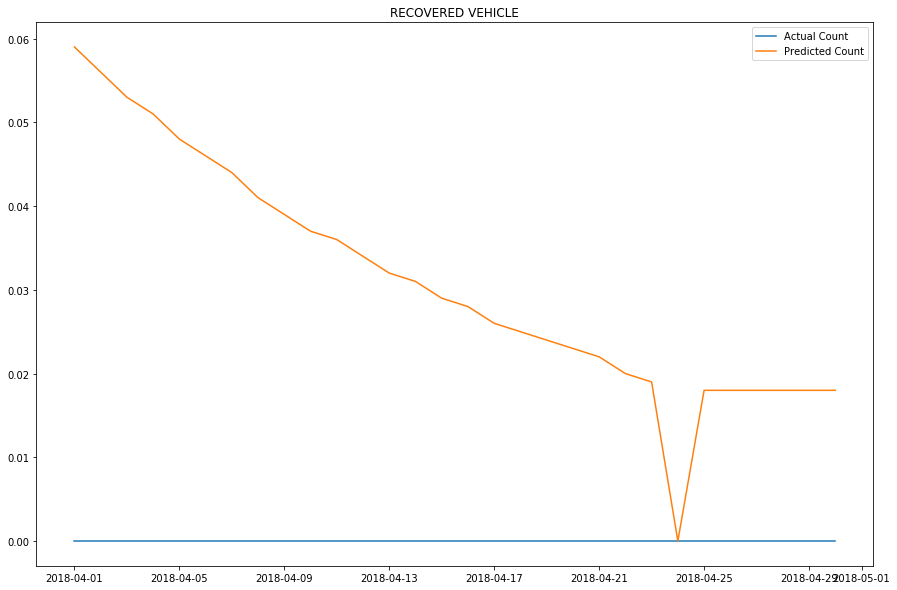

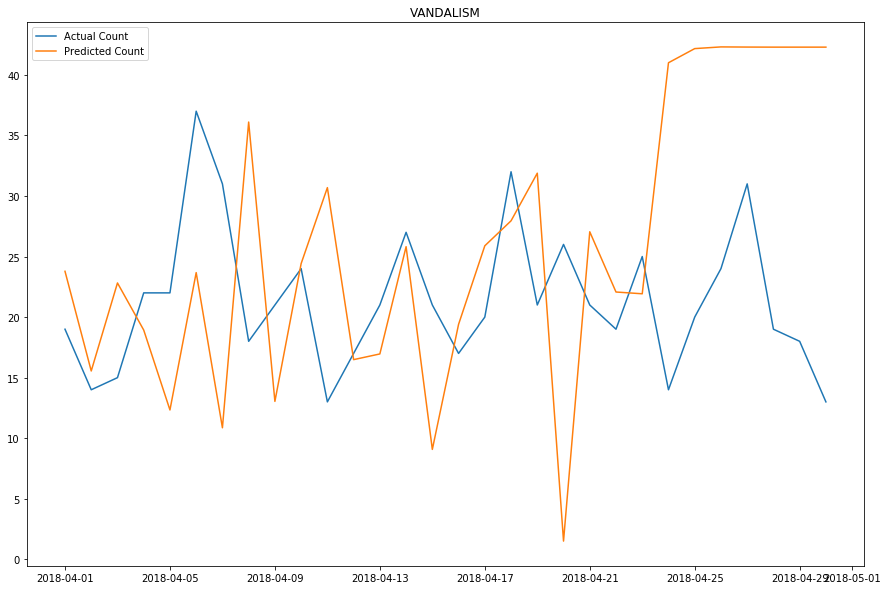

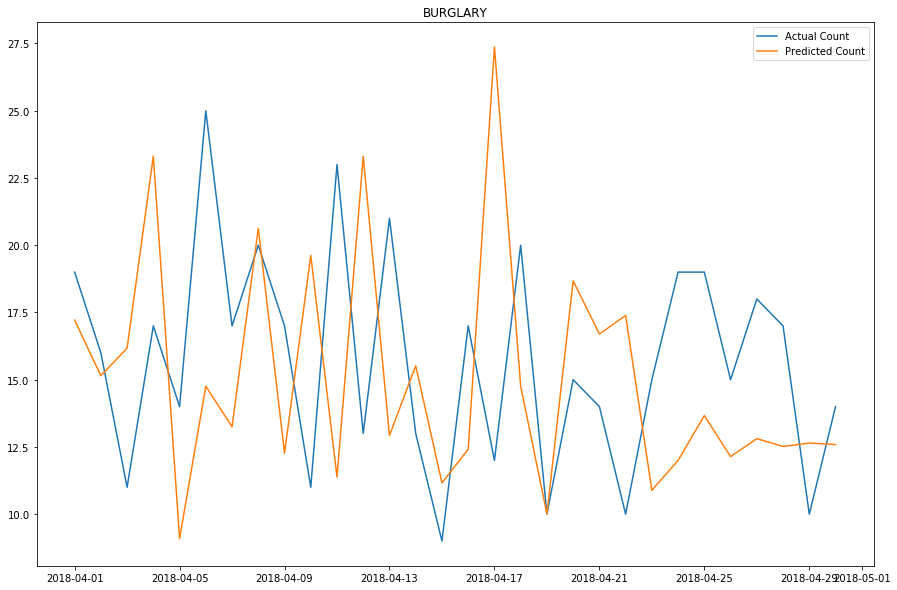

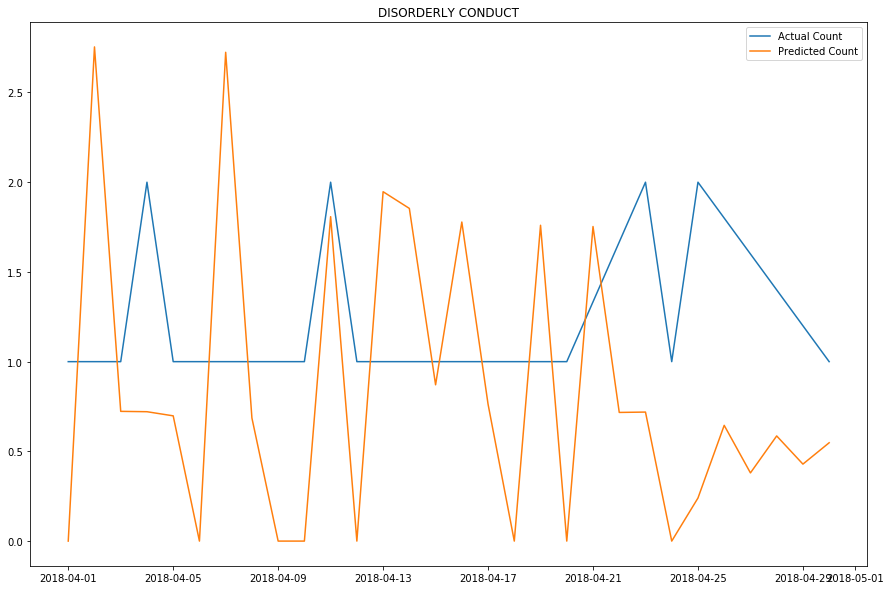

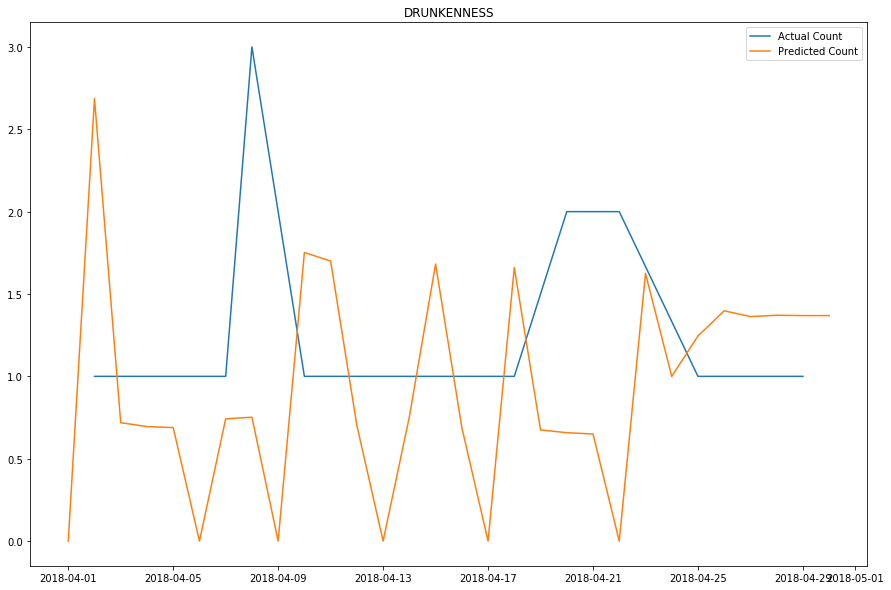

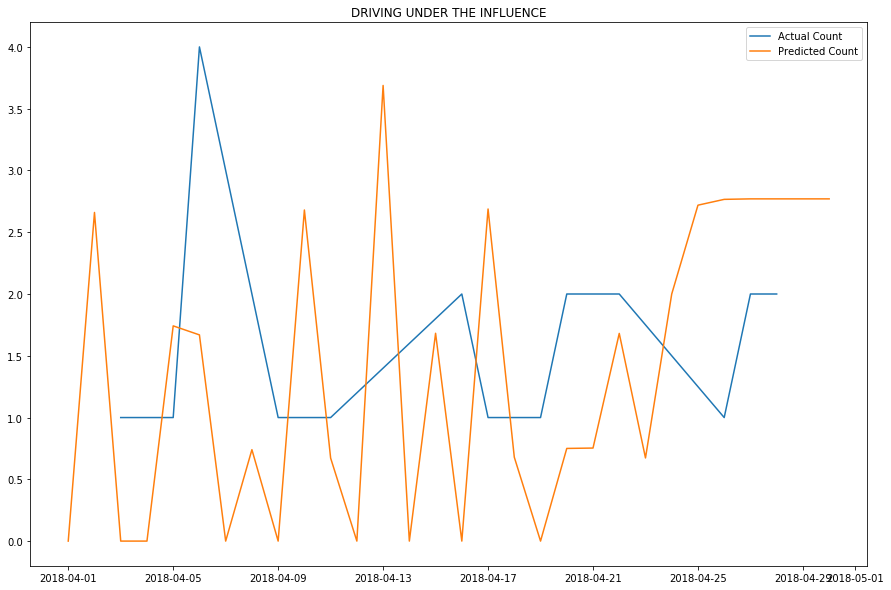

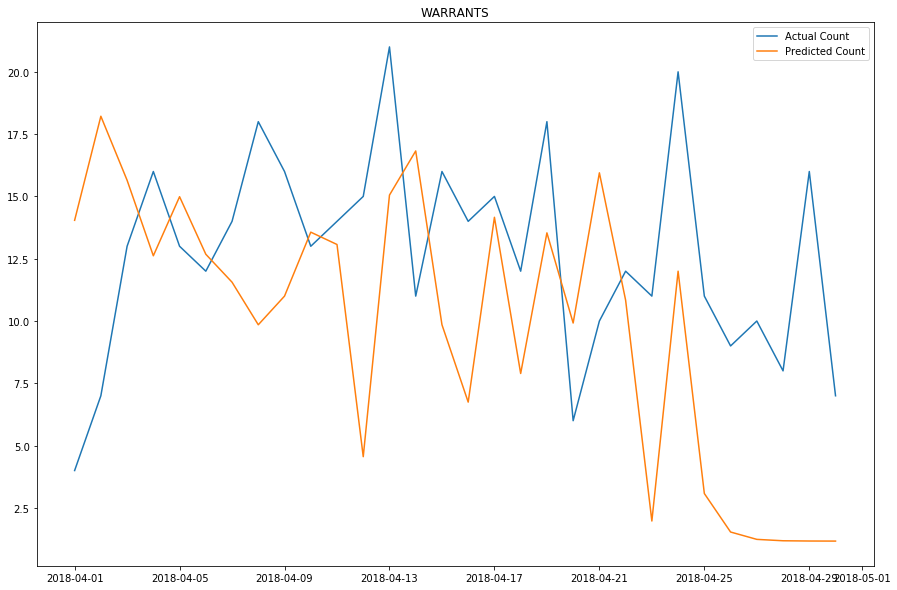

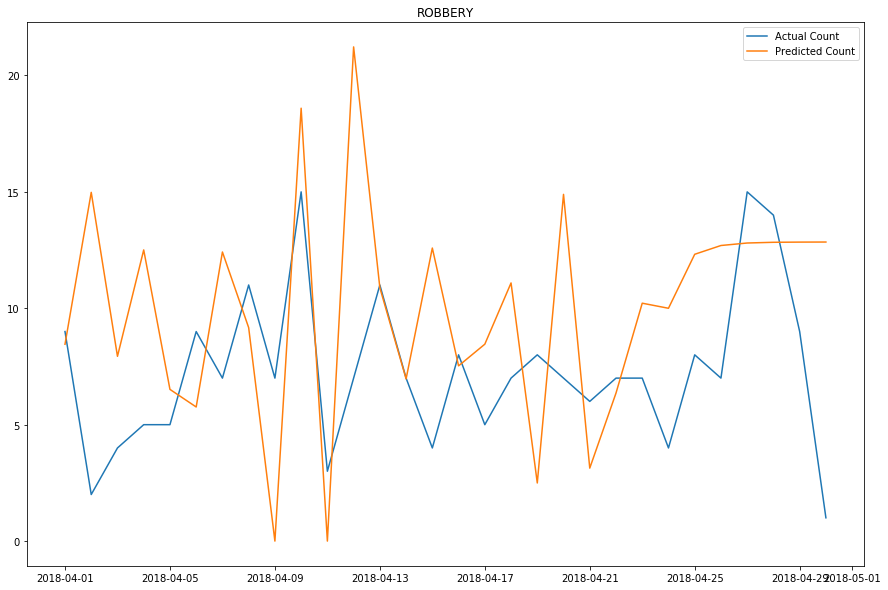

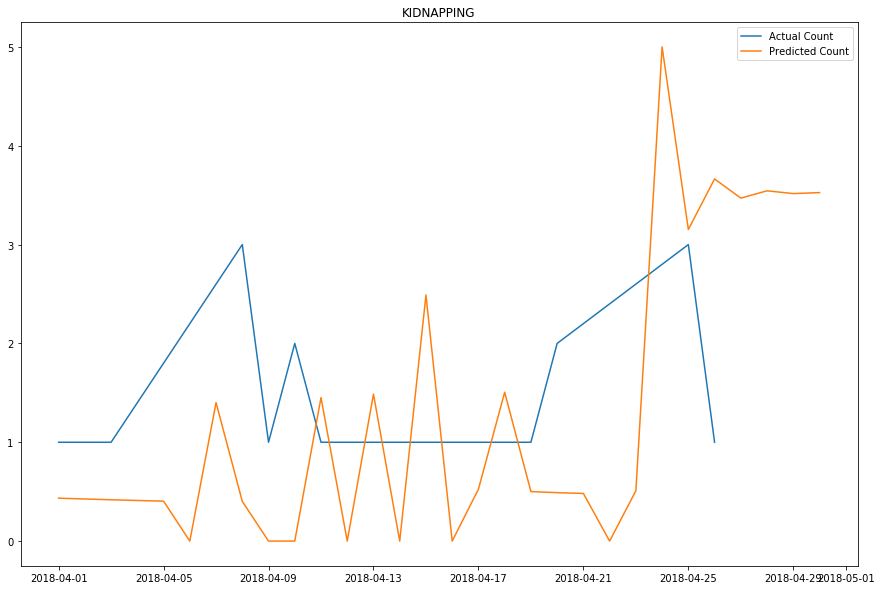

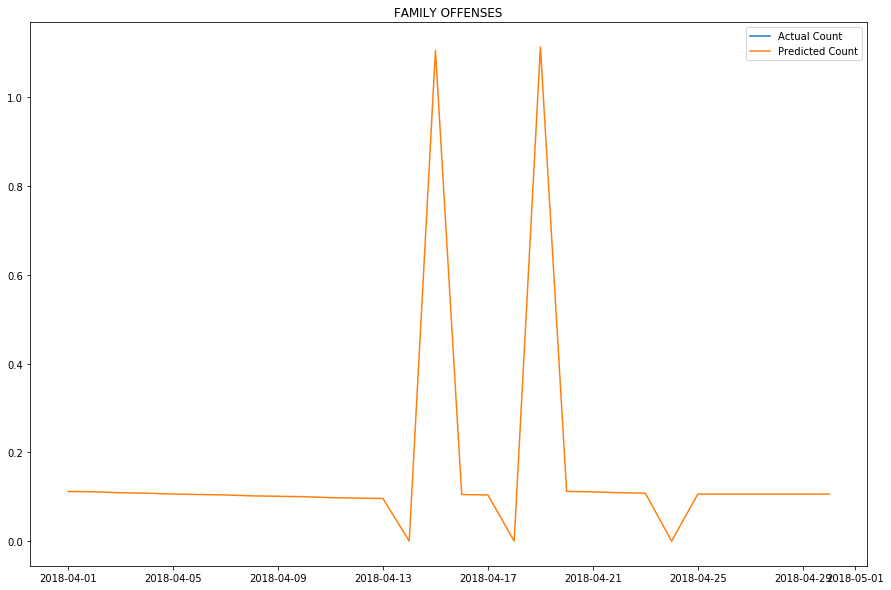

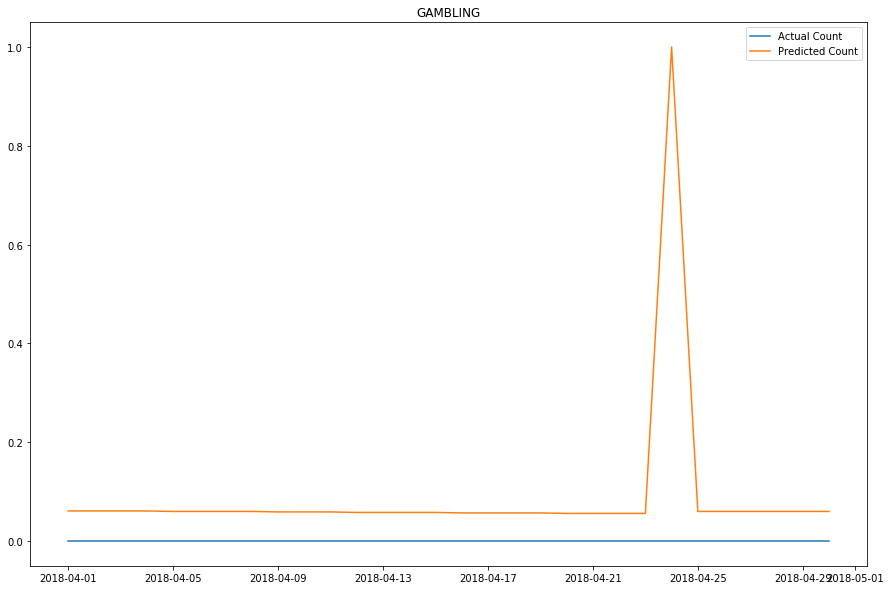

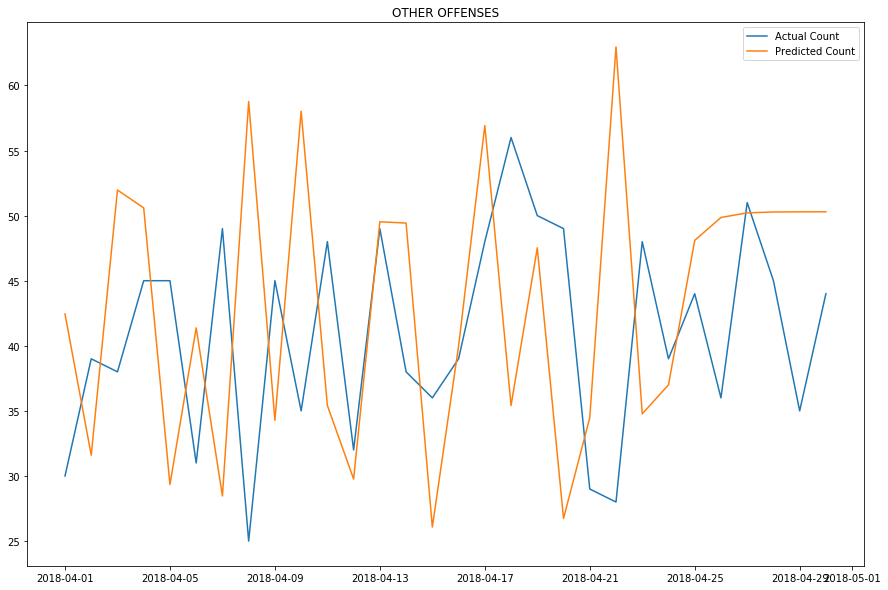

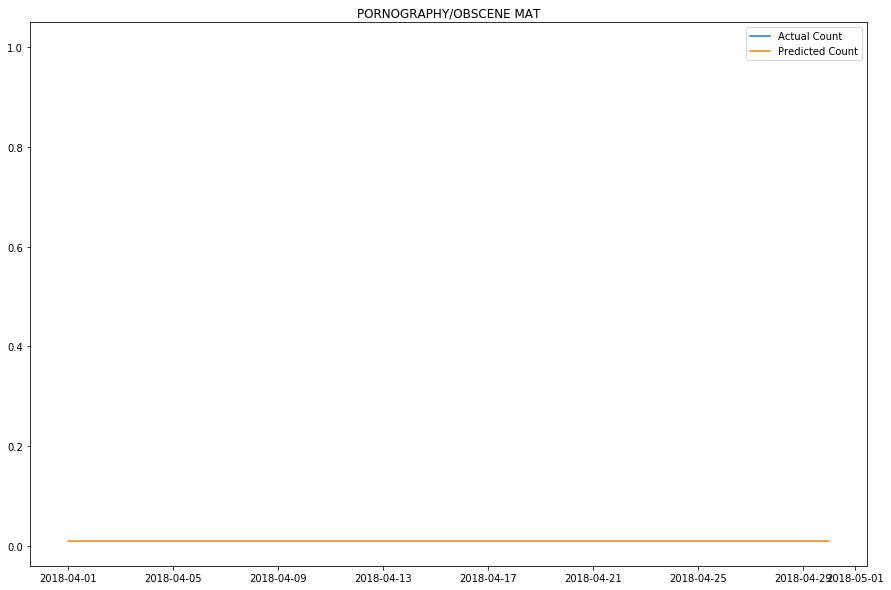

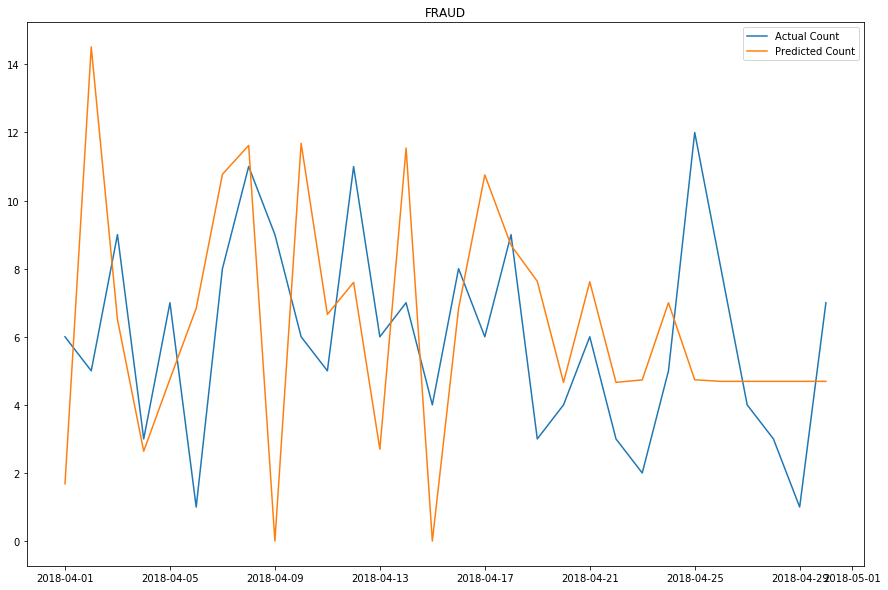

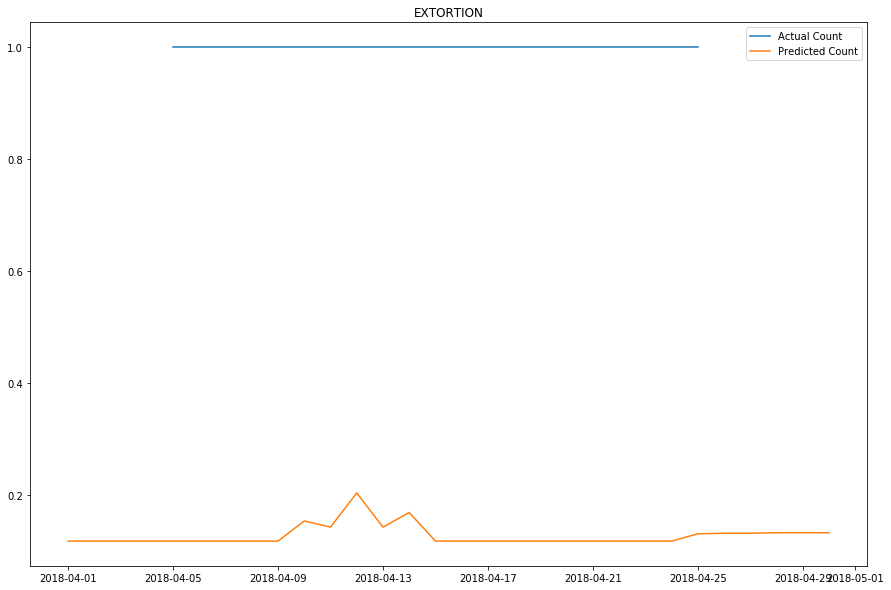

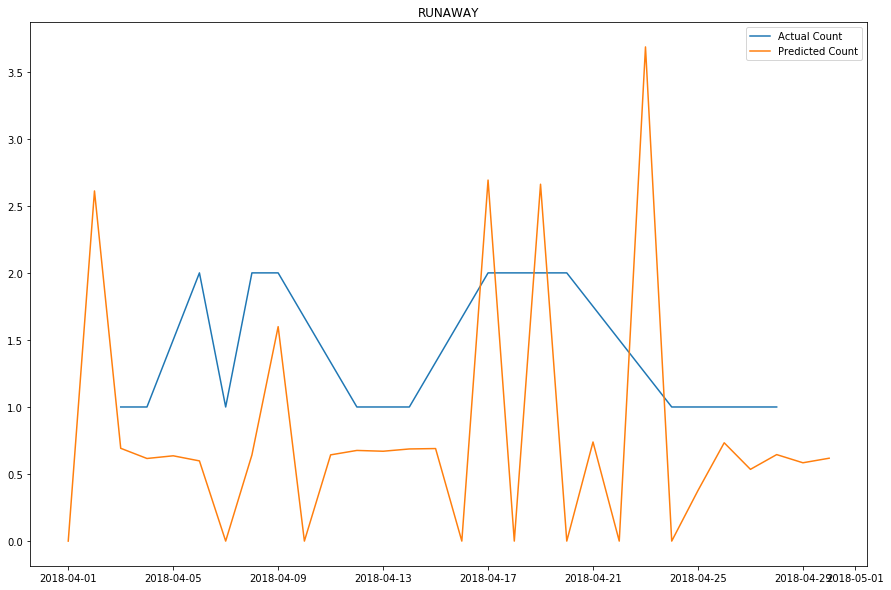

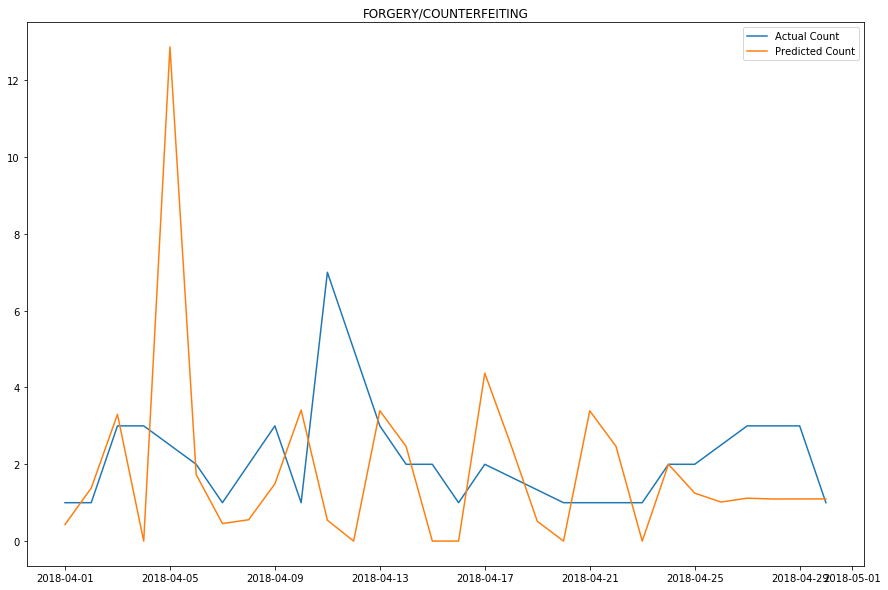

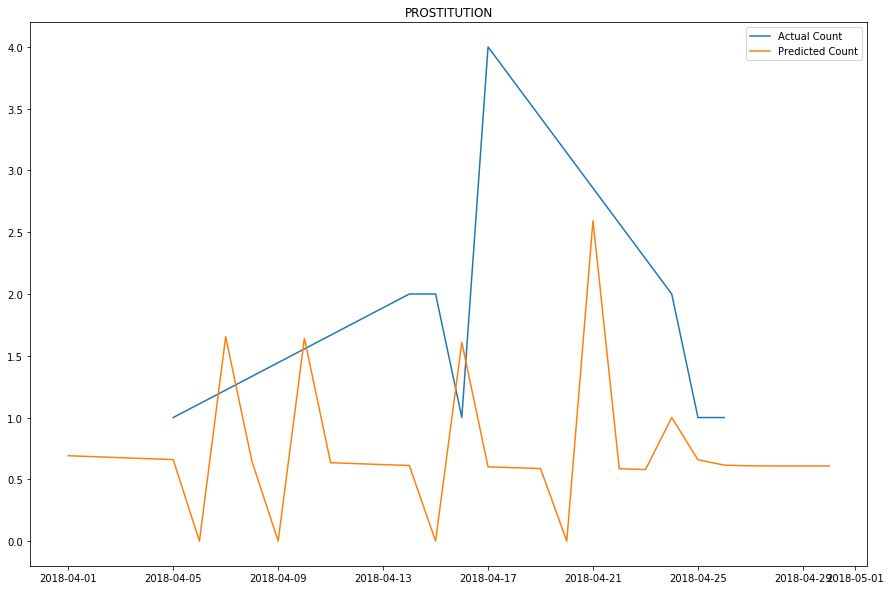

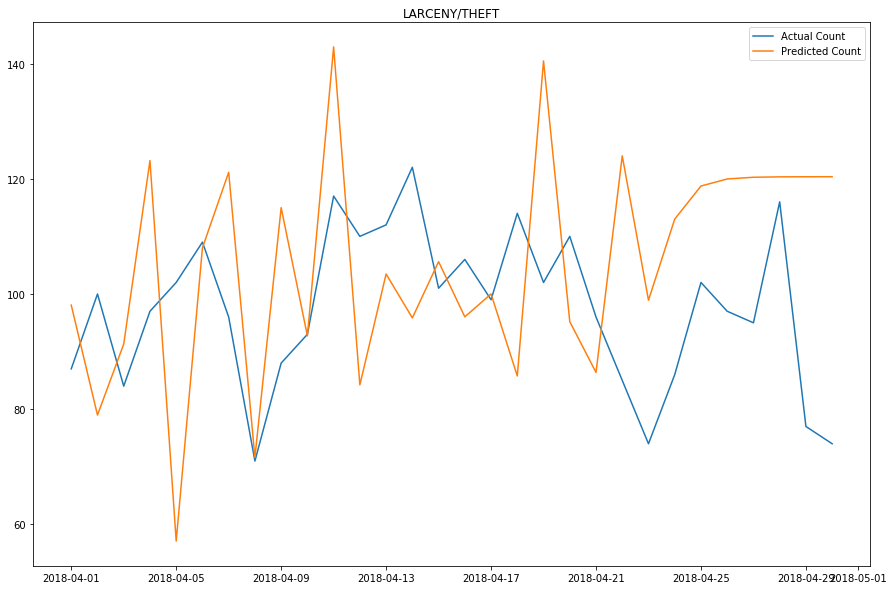

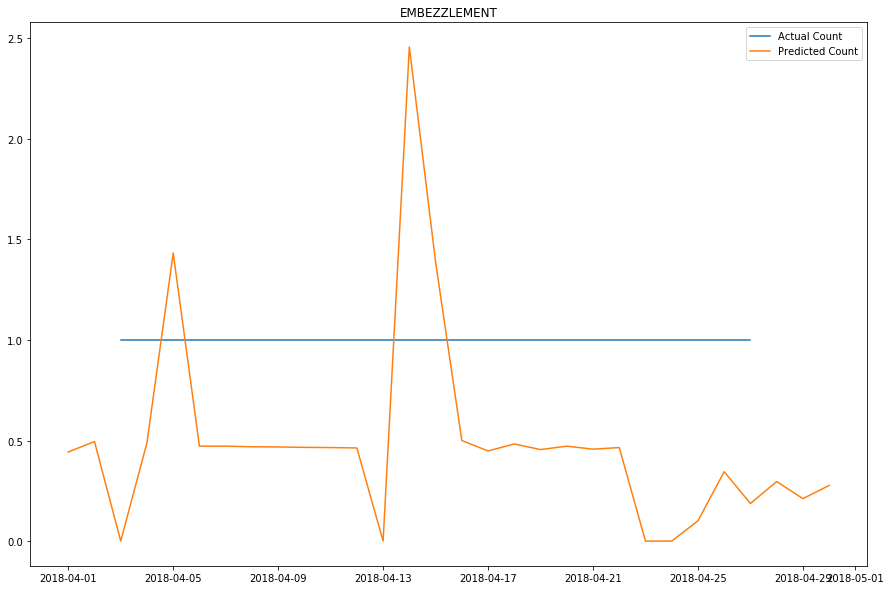

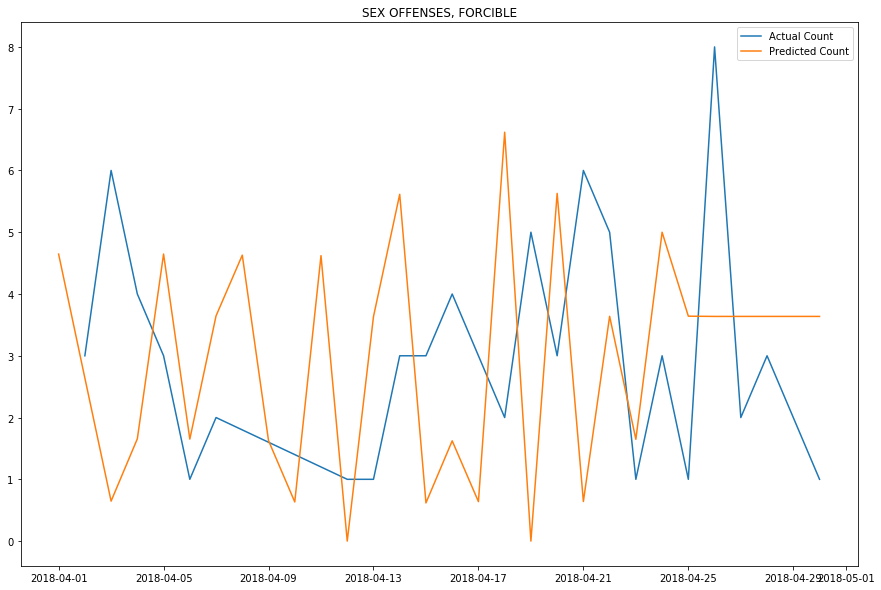

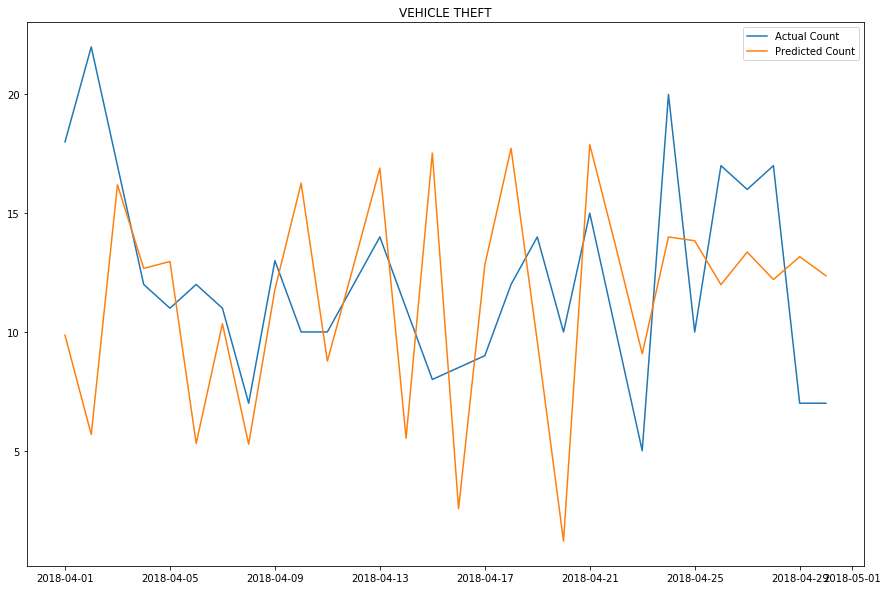

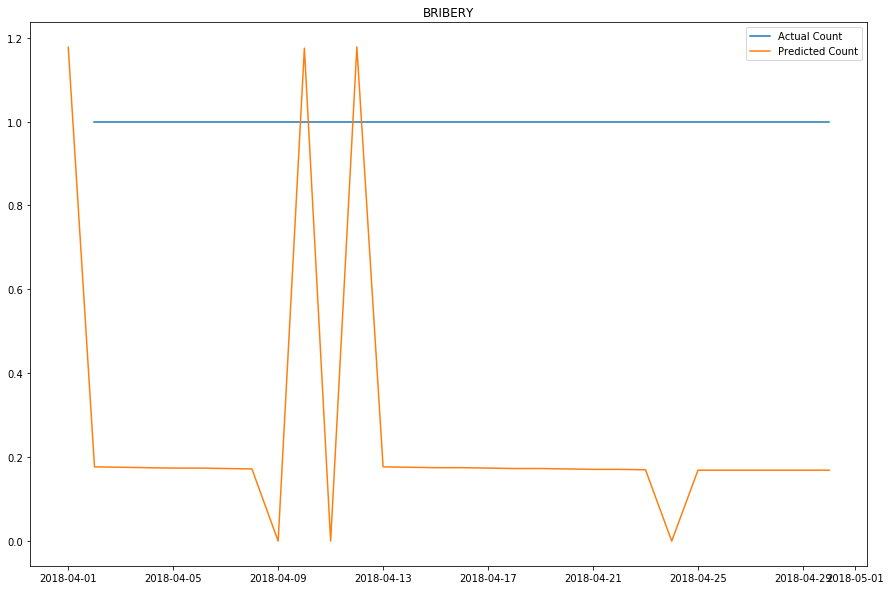

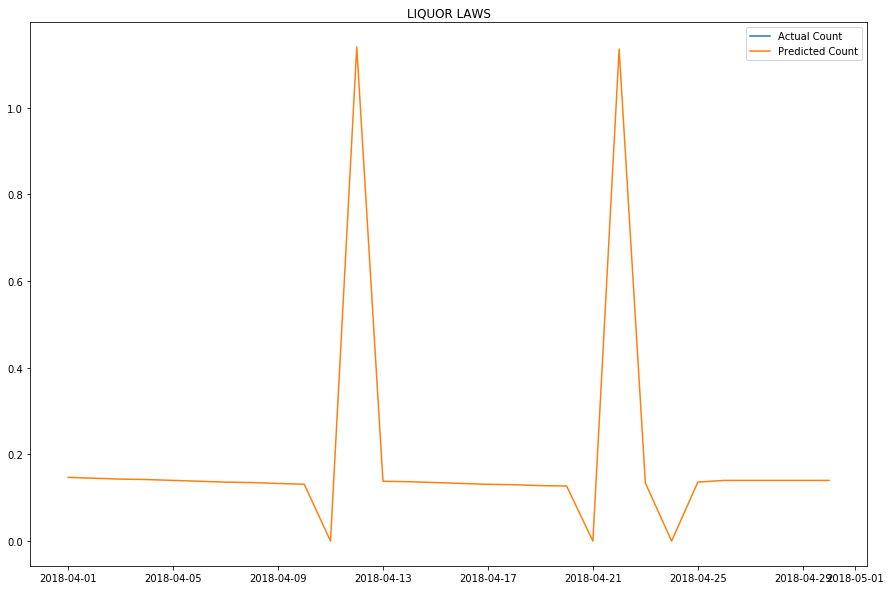

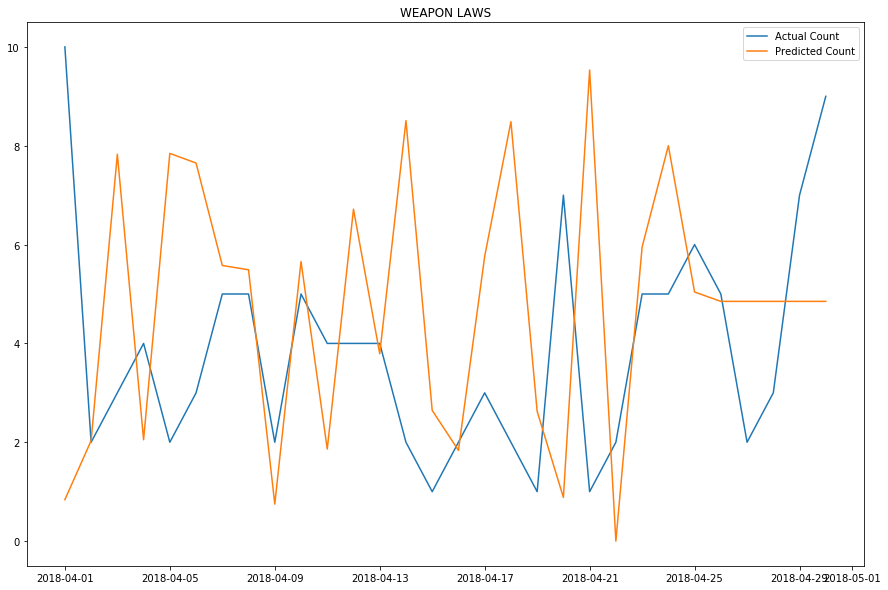

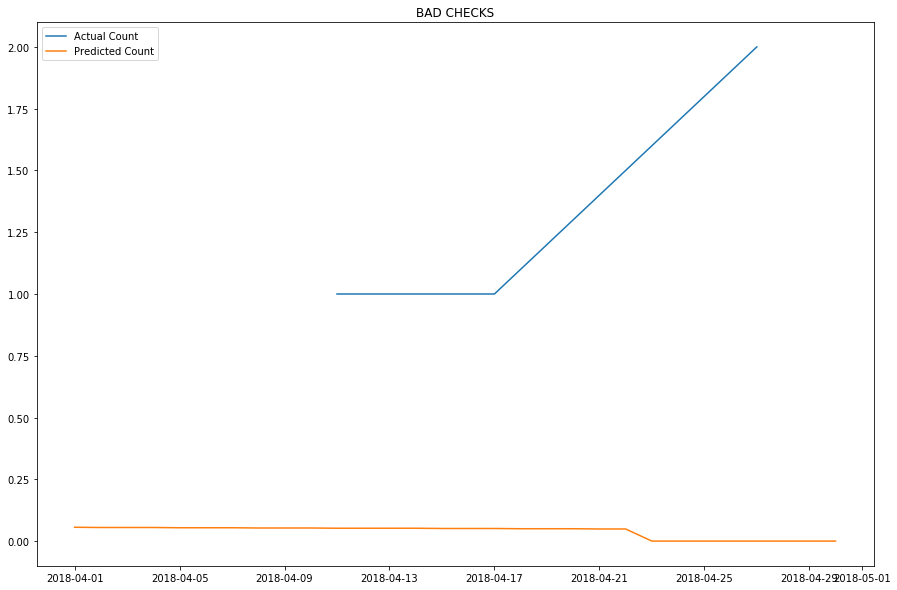

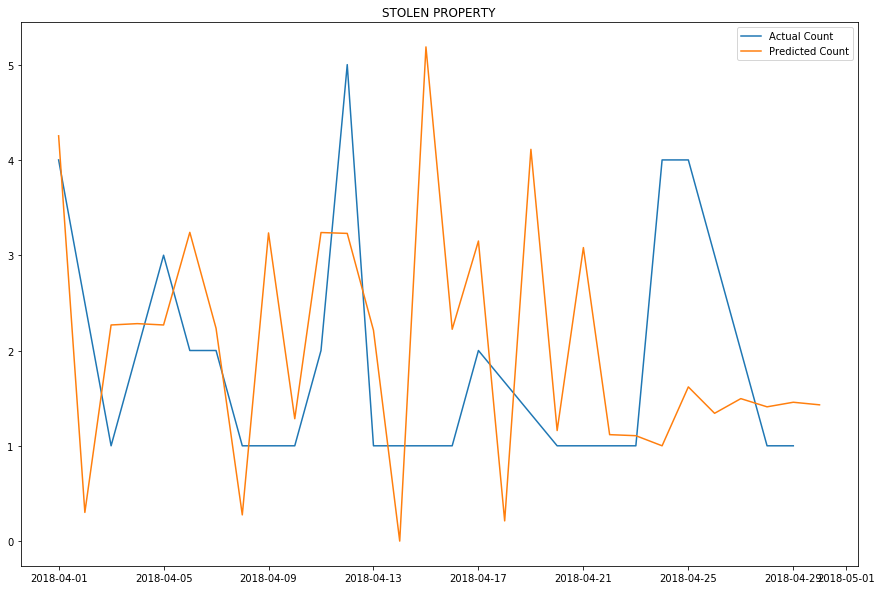

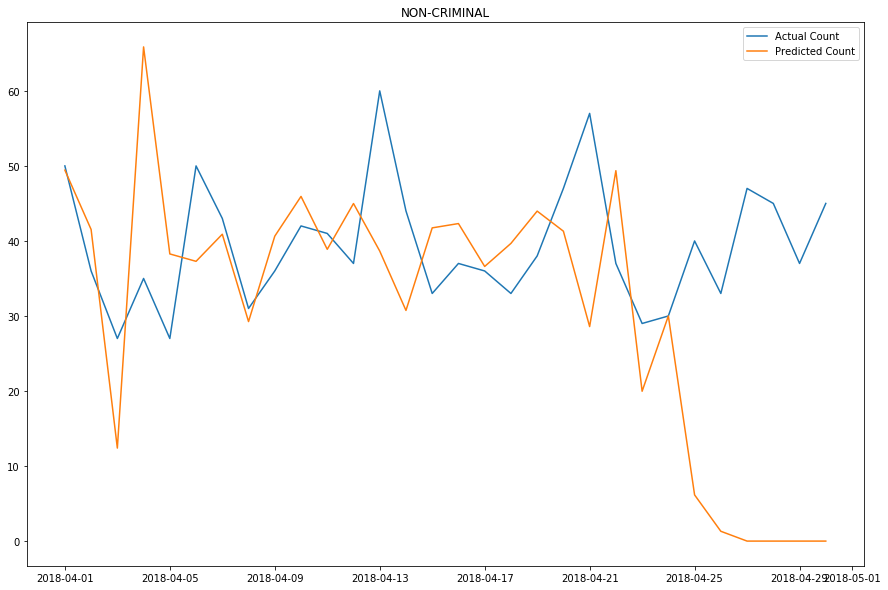

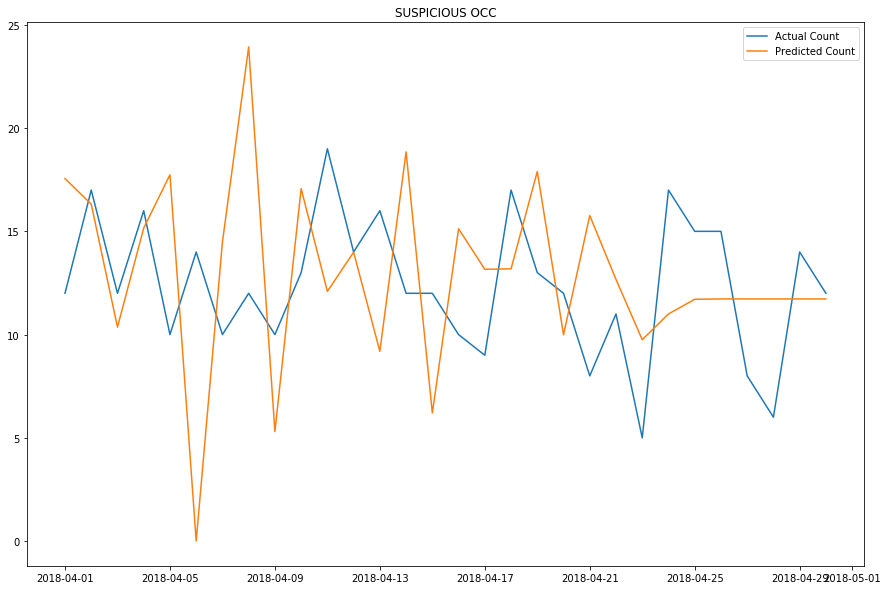

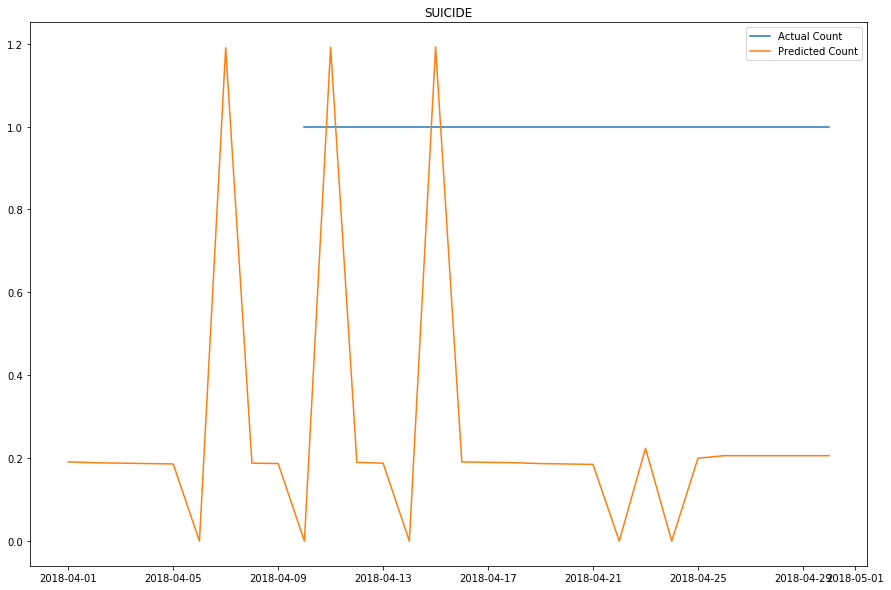

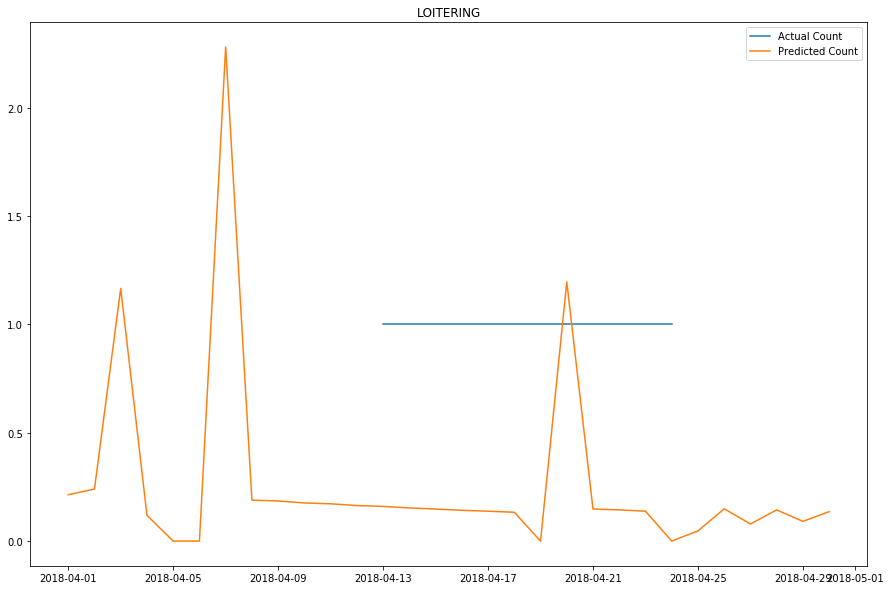

In [122]:
from pyspark.ml.linalg import Vectors

base = datetime.datetime(2018, 4, 1, 0, 0)
date_list = [base + datetime.timedelta(days=x) for x in range(0, 30)]

for entry in ts_list:
    label = entry[0]

    arimaModel = ARIMA.autofit(ts=entry[1], sc=sc)
    prediction = arimaModel.forecast(entry[1], 7)
    fut = Vectors.dense(np.around(np.clip(a=prediction.toArray()[len(prediction.toArray()) - (30 + 1) : len(prediction.toArray()) - 1], a_min=0.000, a_max=None), decimals=3))
    
    dates = crime_date_count_sample_future.where(crime_date_count_sample_future.Category == label).select("Date").collect()    
    realcount = crime_date_count_sample_future.where(crime_date_count_sample_future.Category == label).select("Count").collect()
    
    dates = [r.Date for r in dates]
    realcount = [r.Count for r in realcount]
    
    if (len(dates) == 0):
        dates = date_list
        realcount = np.zeros(30)
    
    plt.figure(figsize=[15,10])
    
    #print(dates)
    plt.title(label)
    plt.plot(dates, realcount, label='Actual Count')
    plt.plot(date_list, fut, label='Predicted Count')
    
    plt.legend()
    
    plt.show()

### Fitting the ARIMA Model with (p, d, q) = (0, 1, 0) : Random Walk

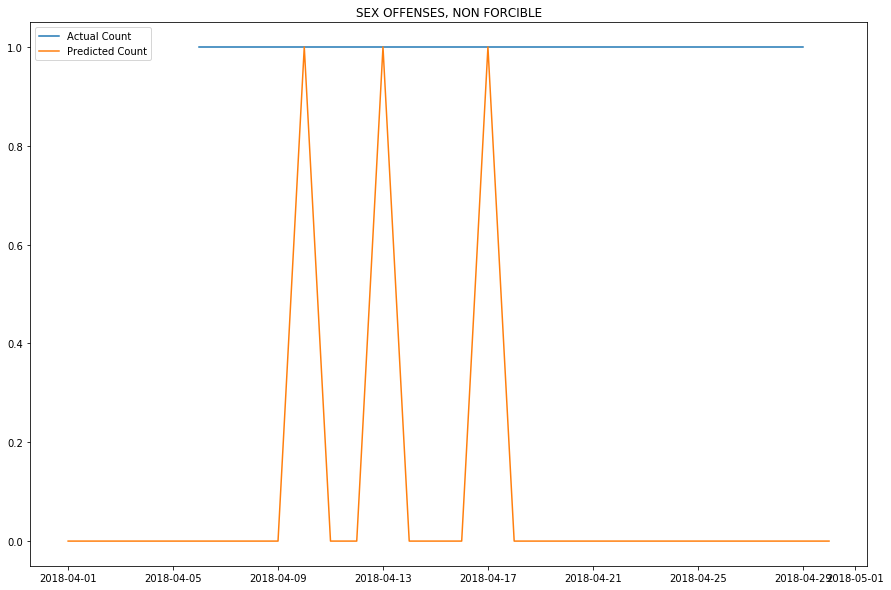

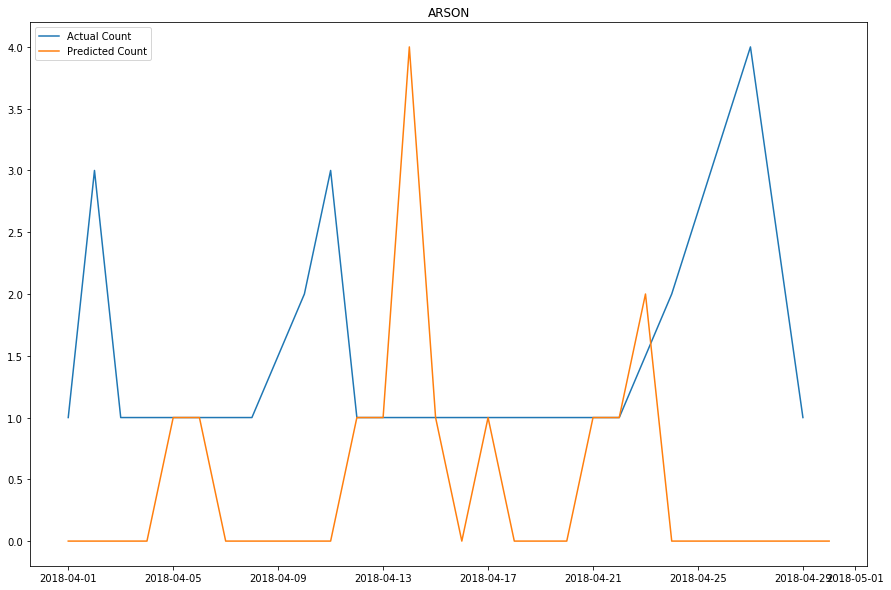

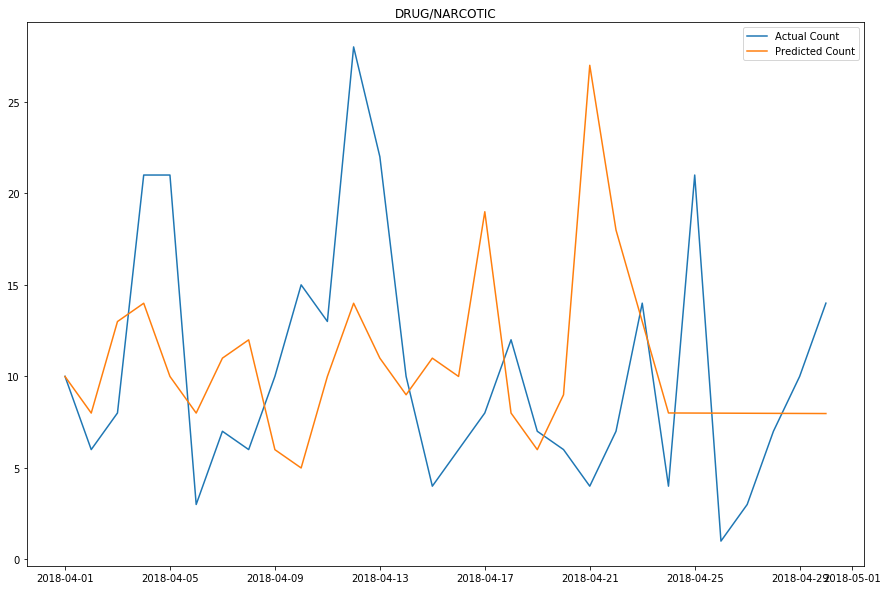

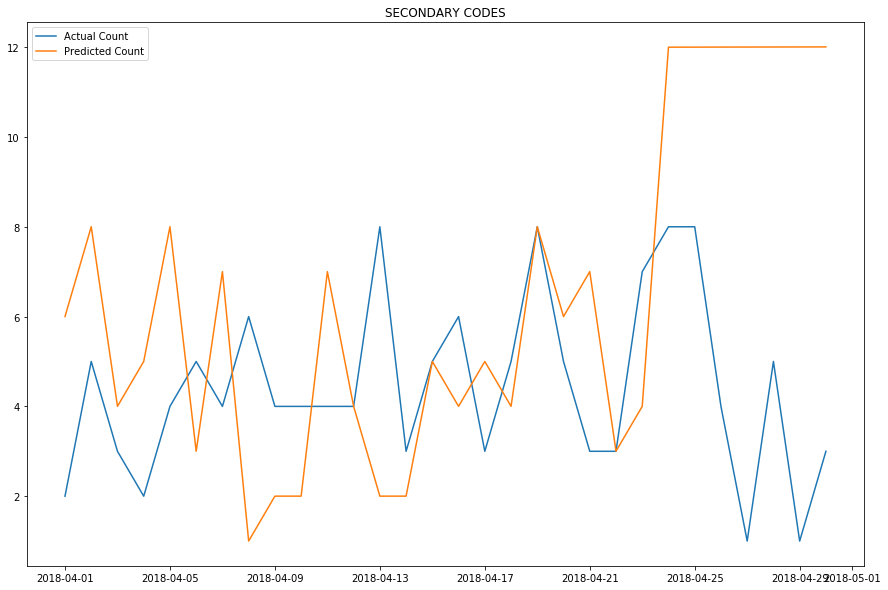

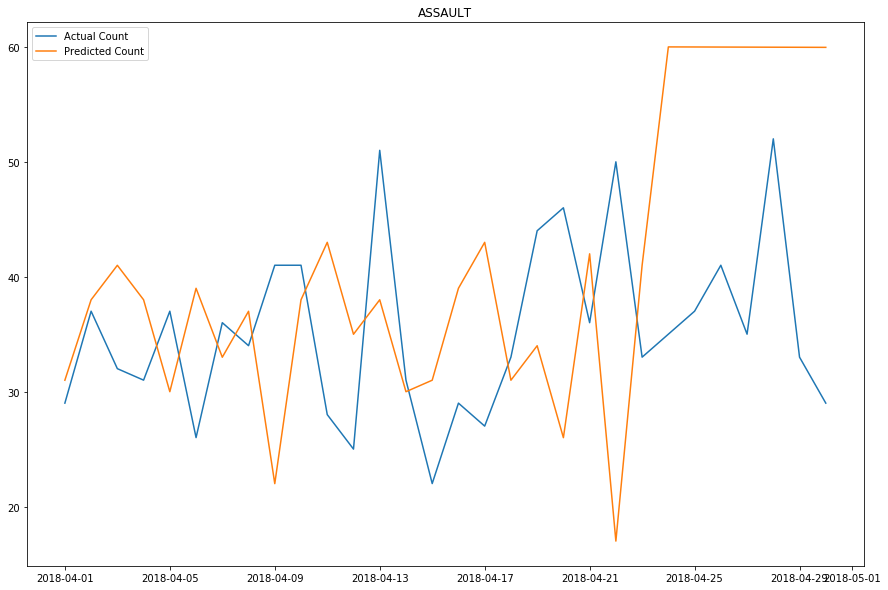

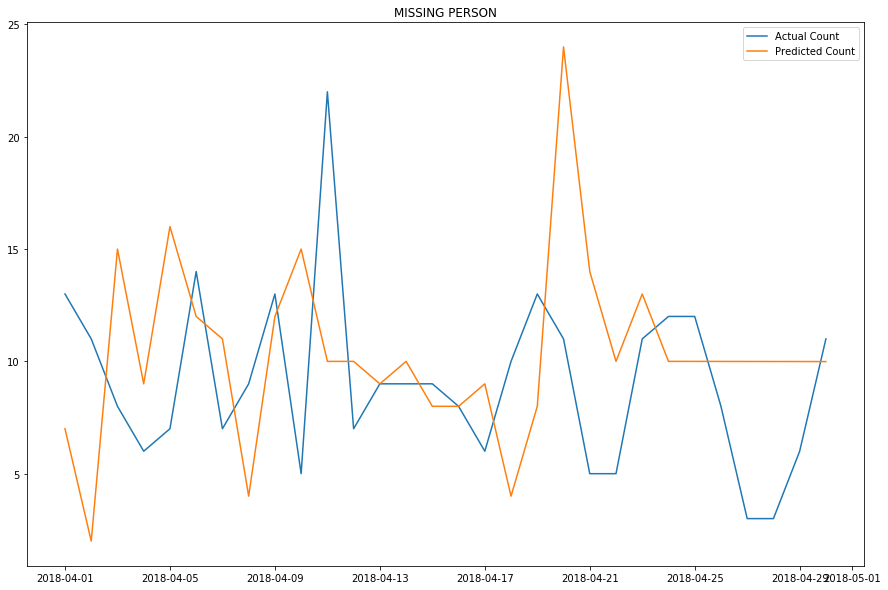

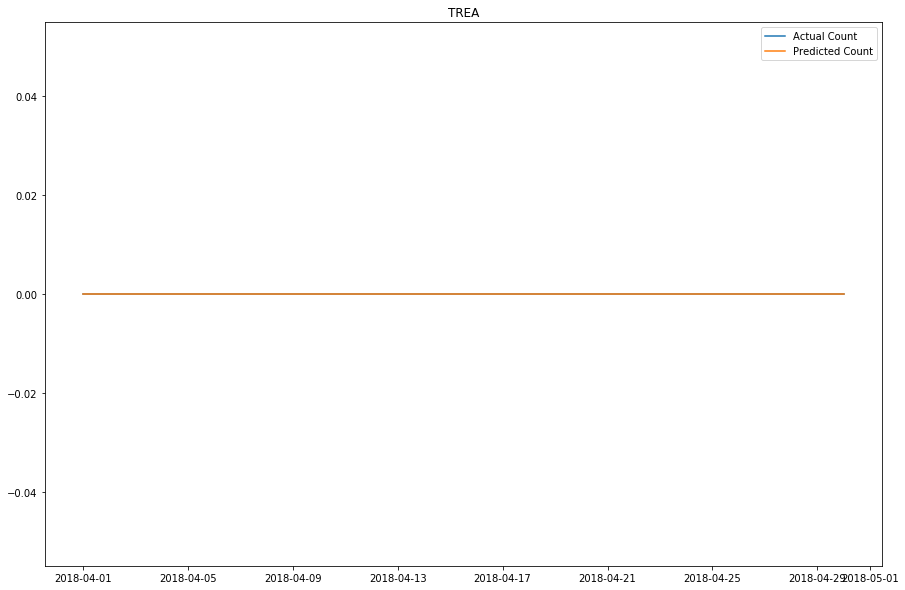

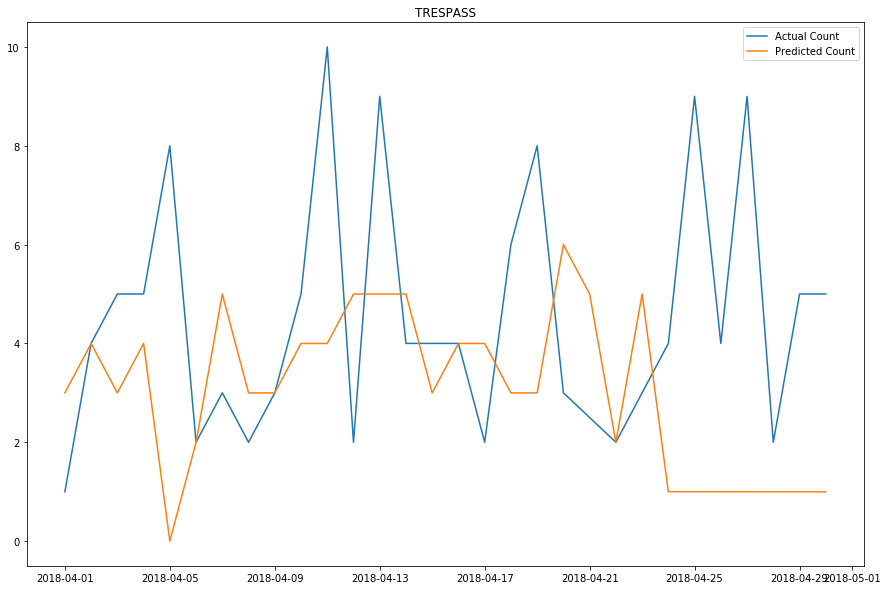

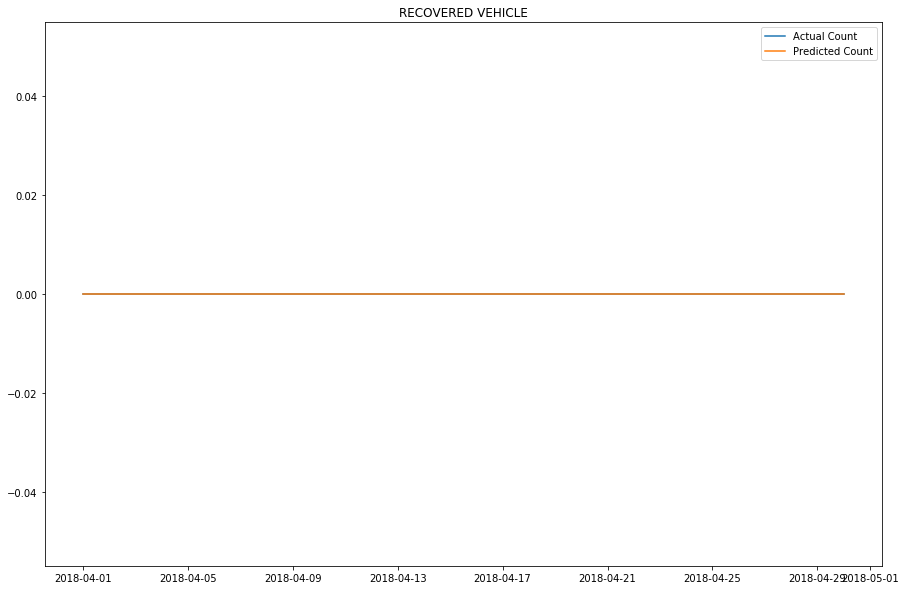

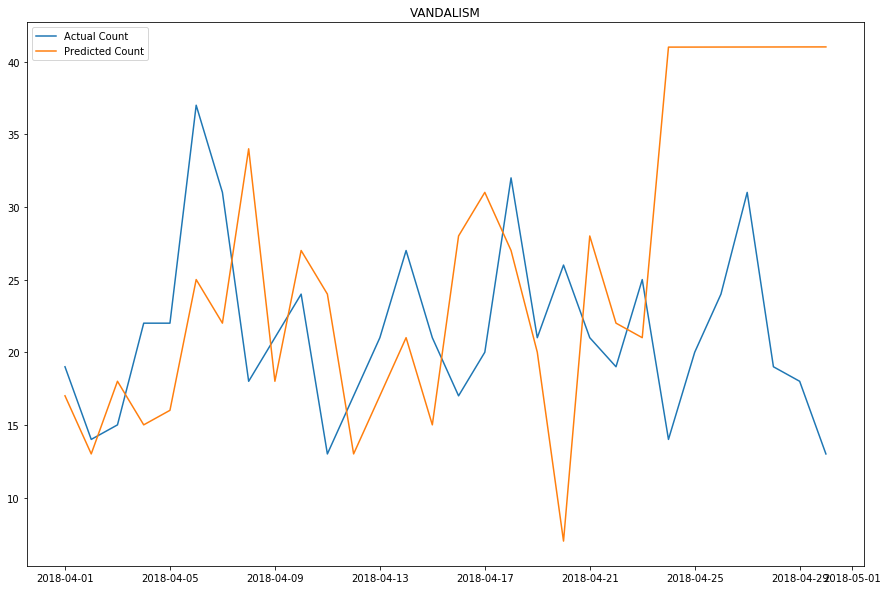

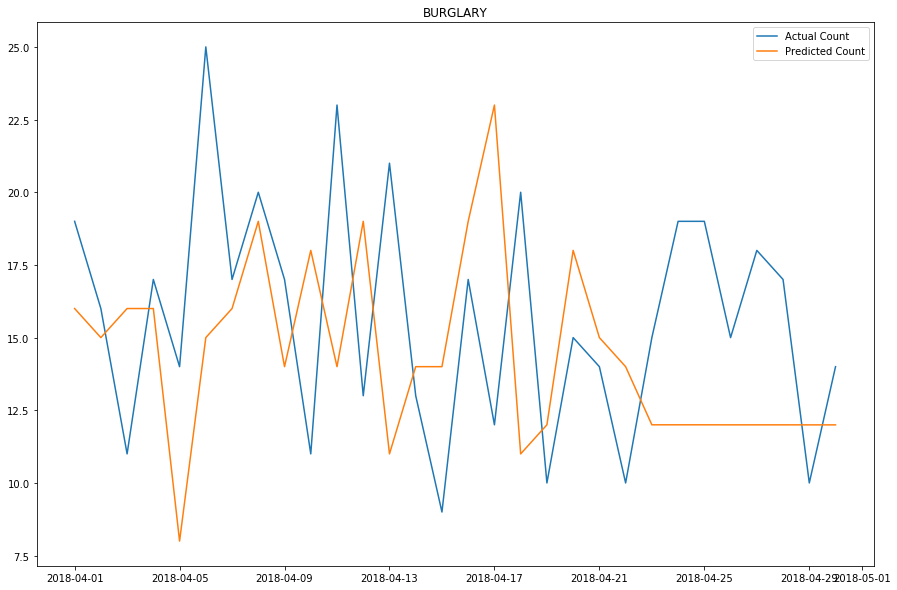

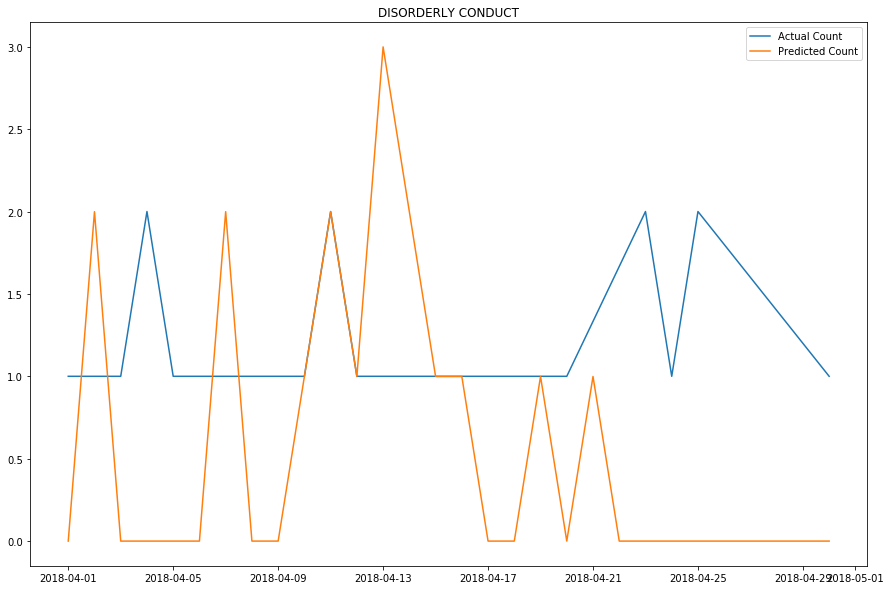

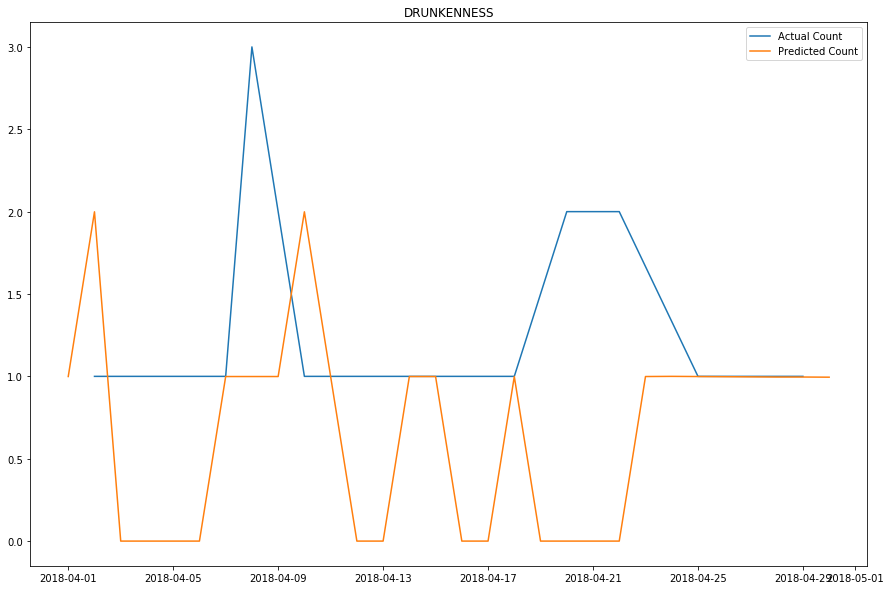

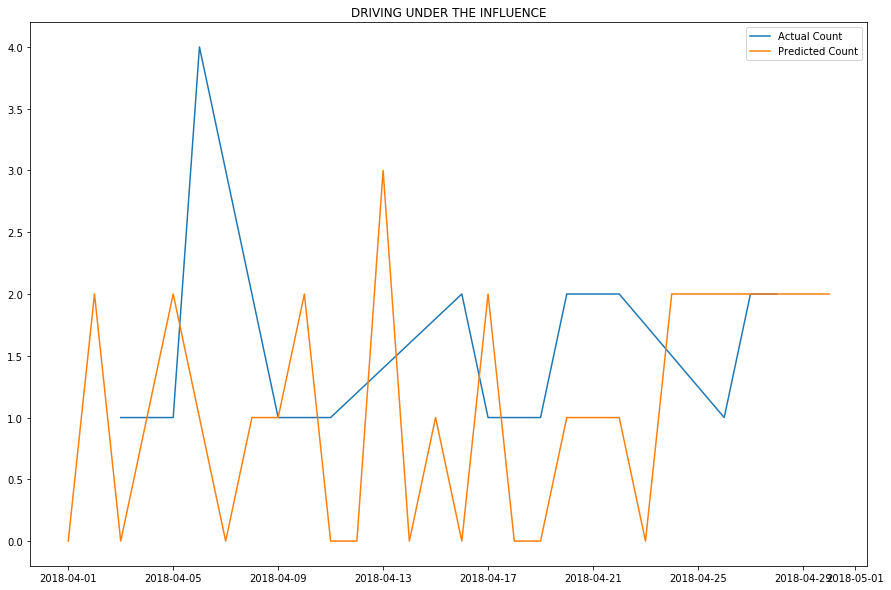

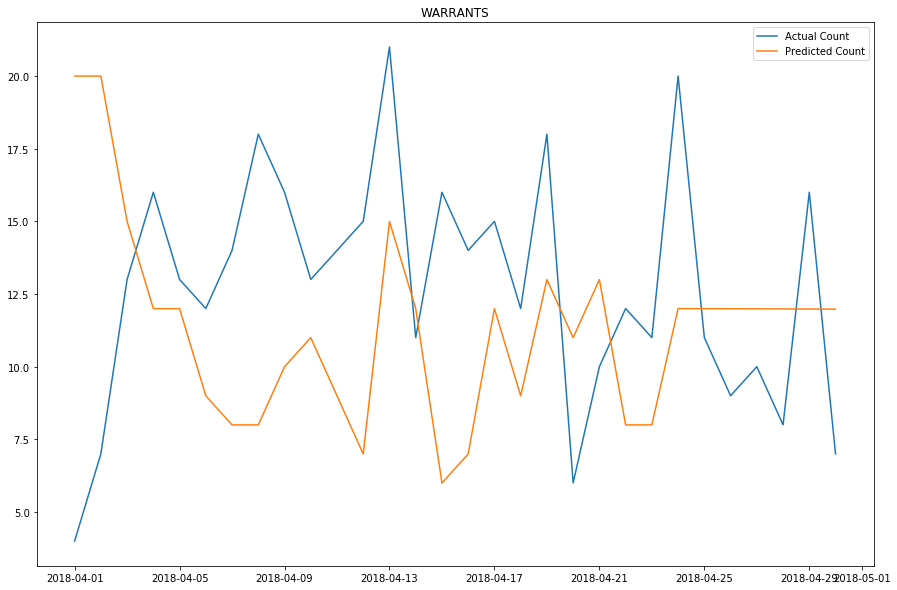

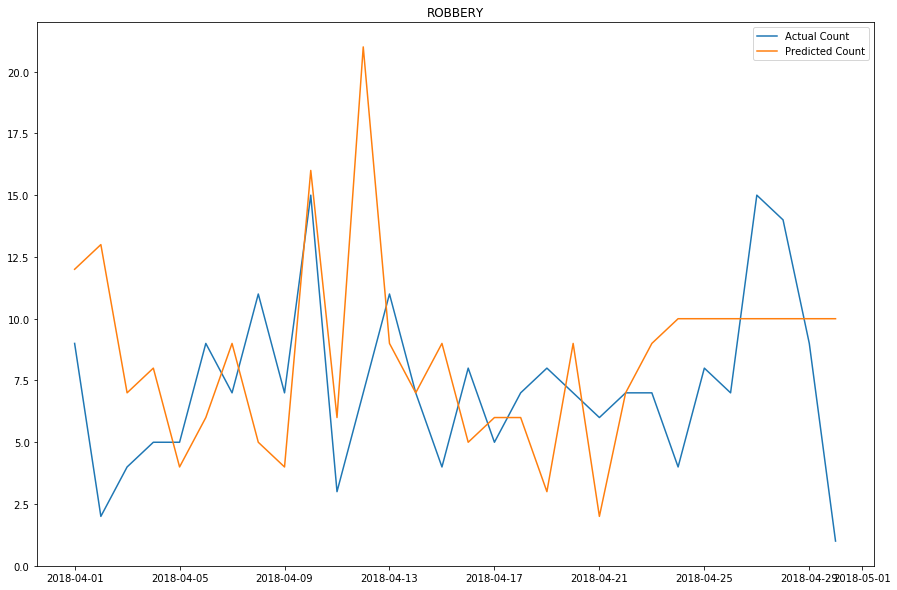

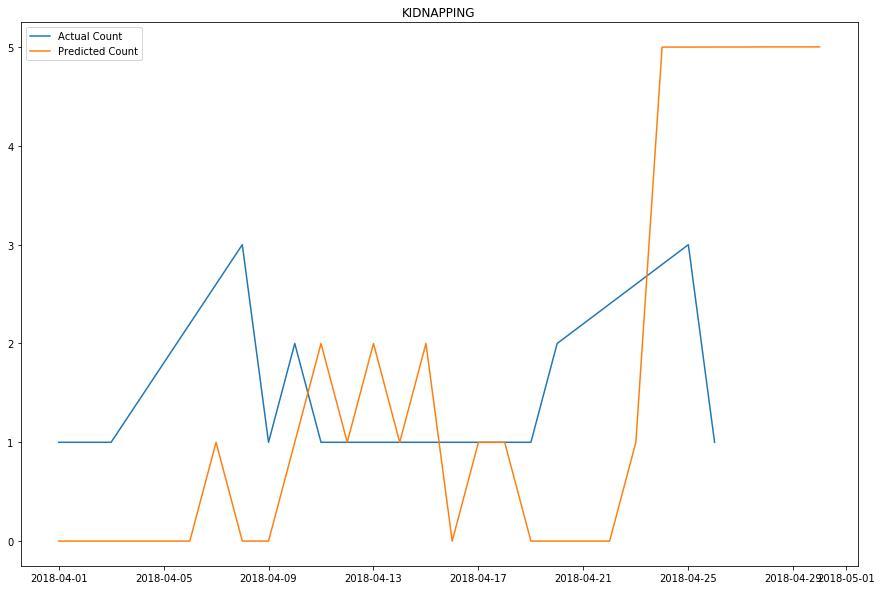

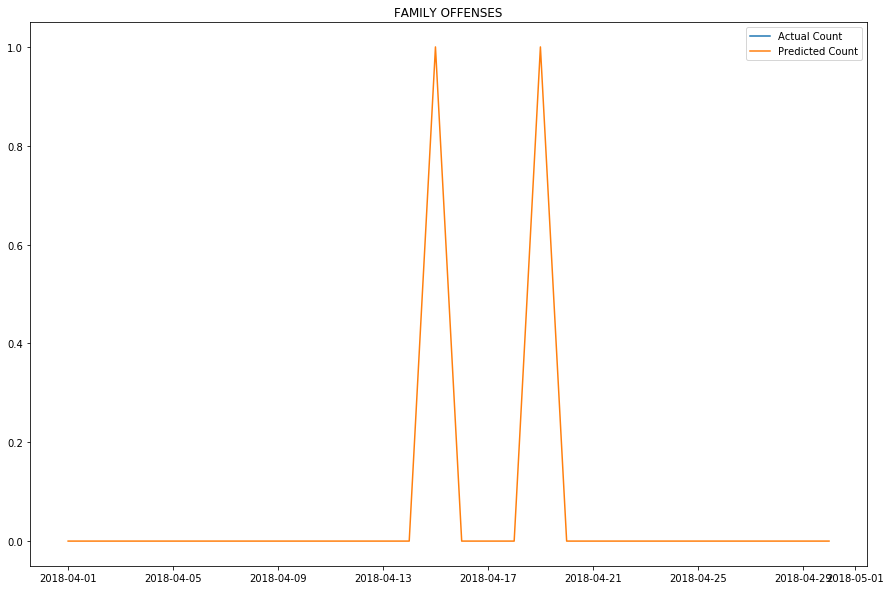

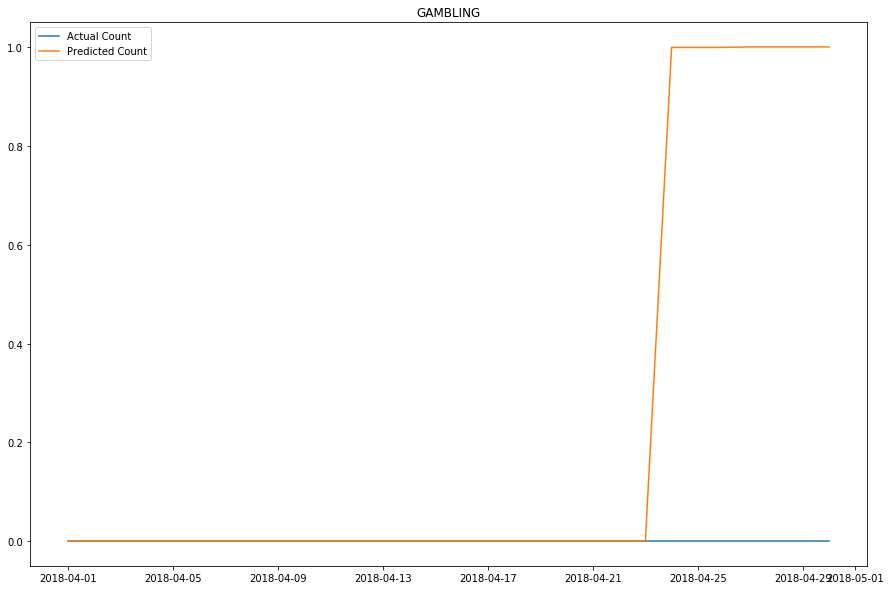

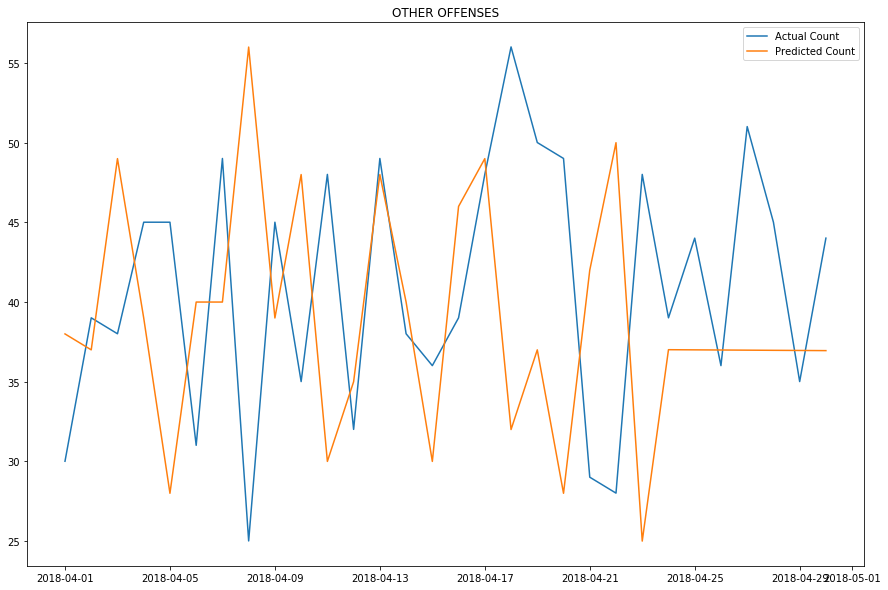

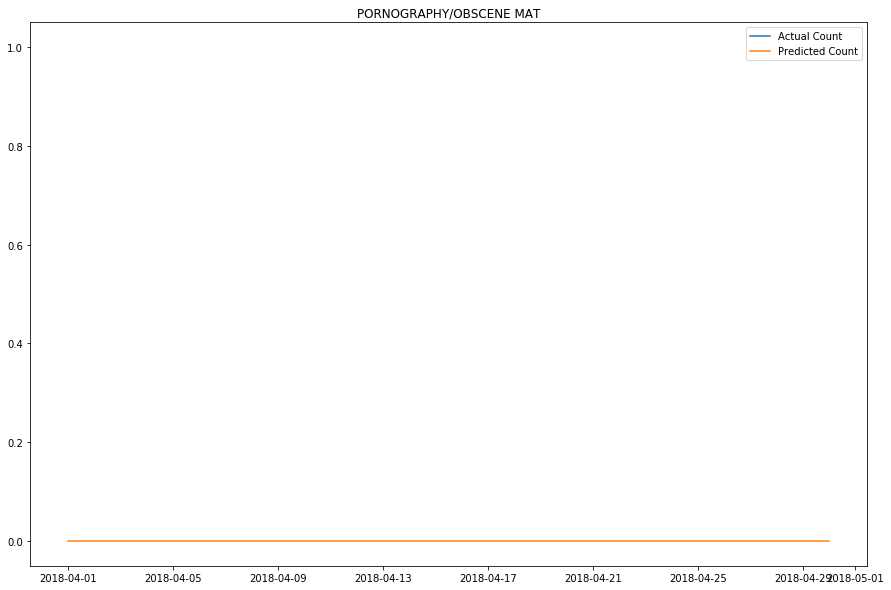

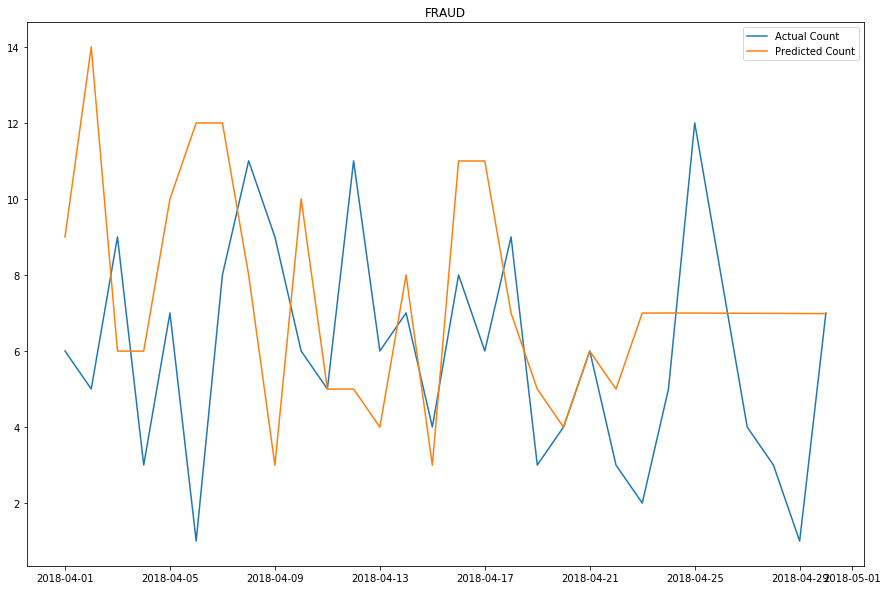

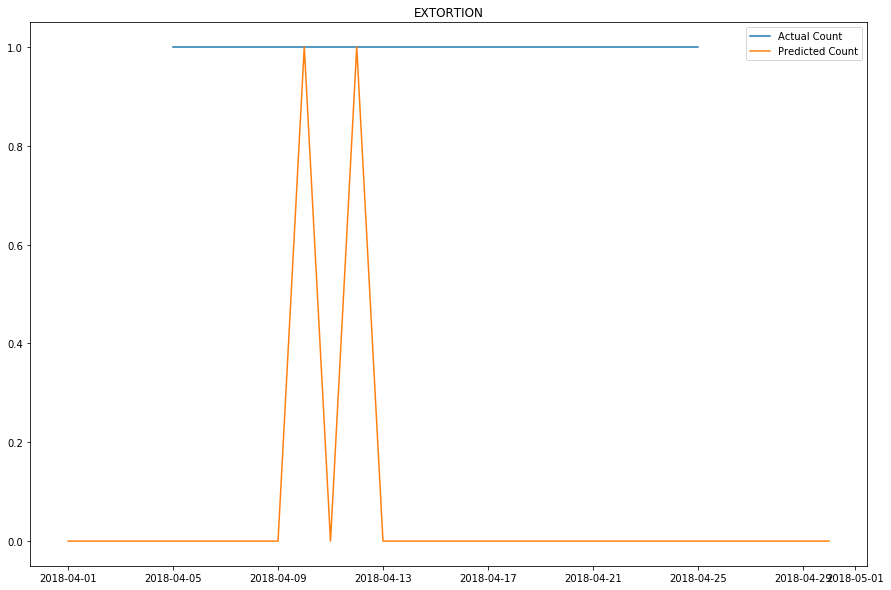

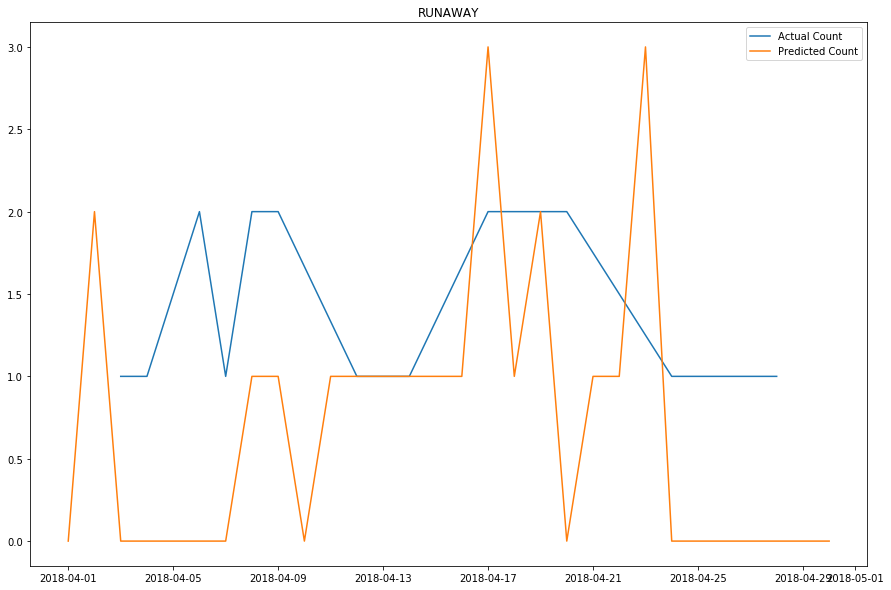

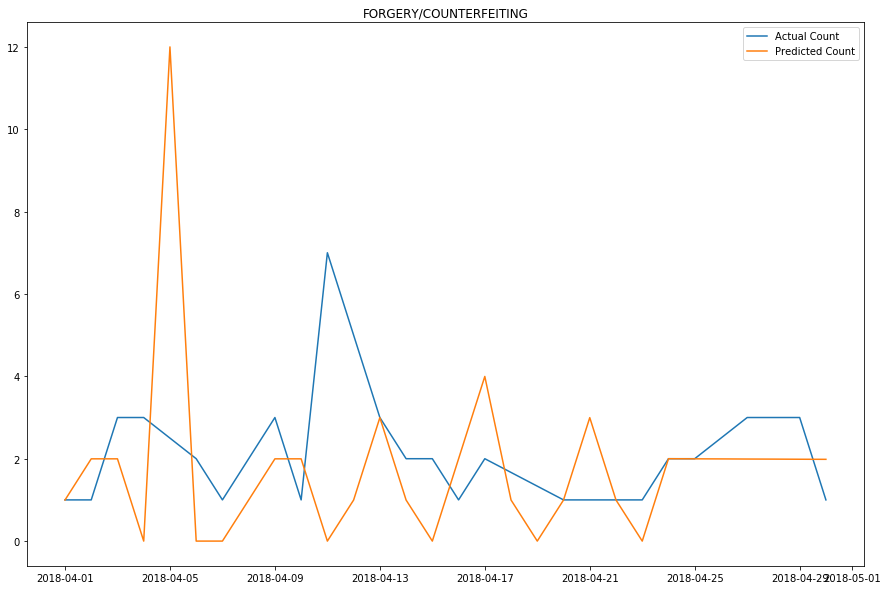

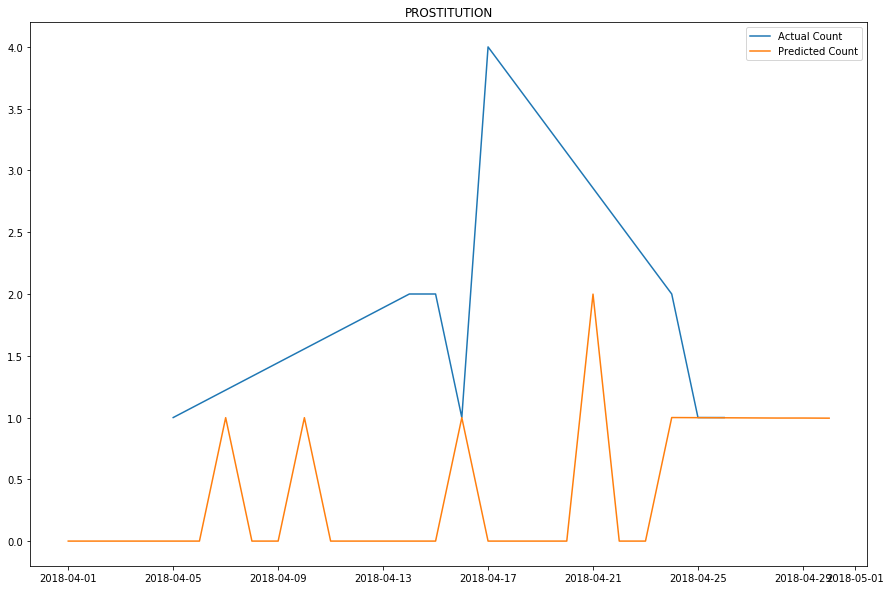

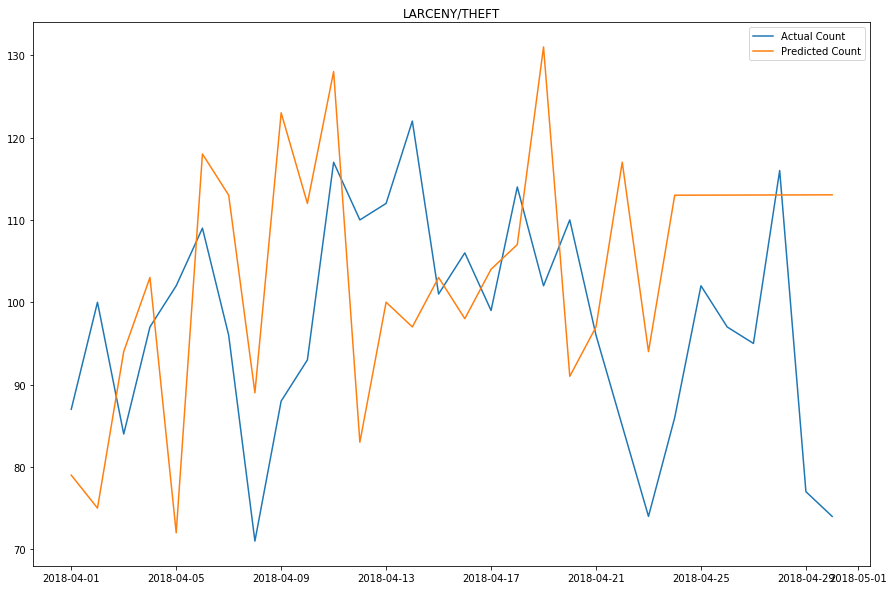

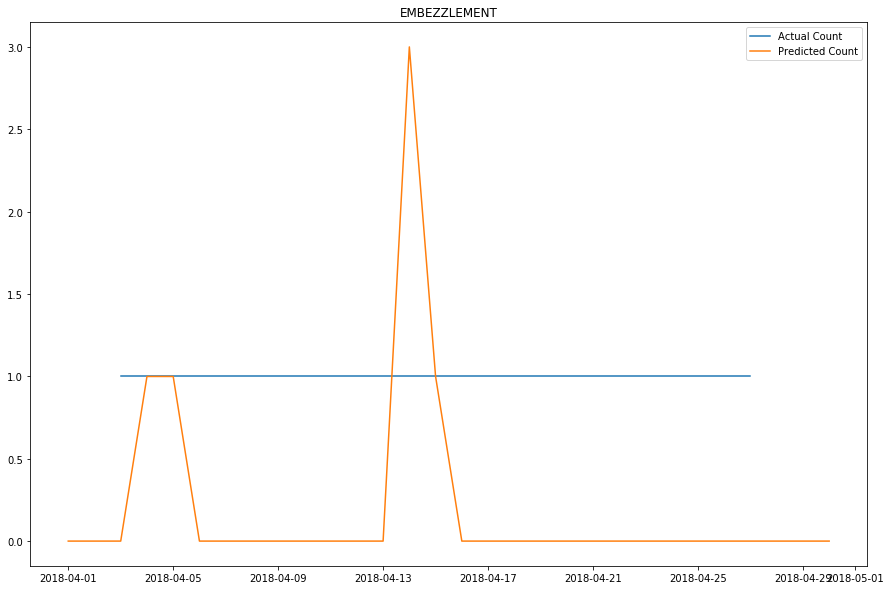

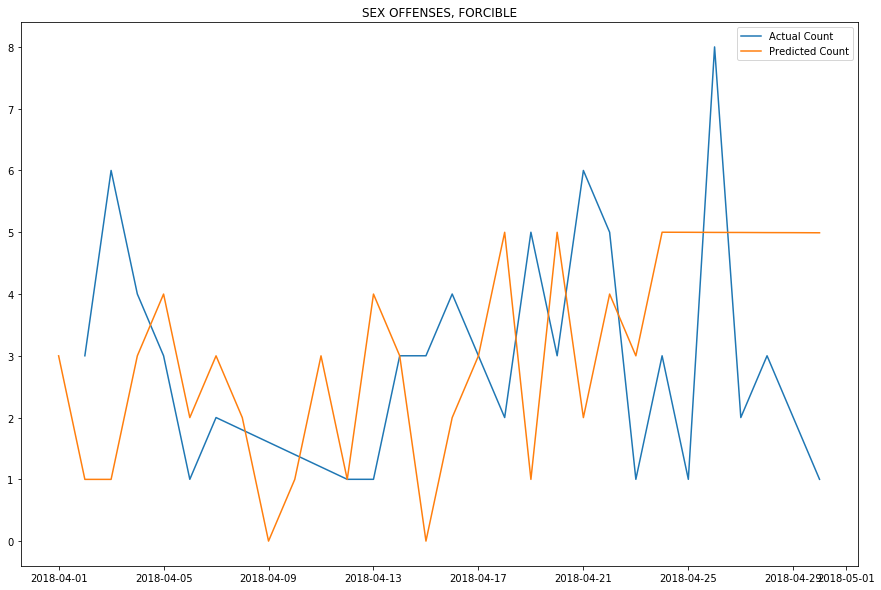

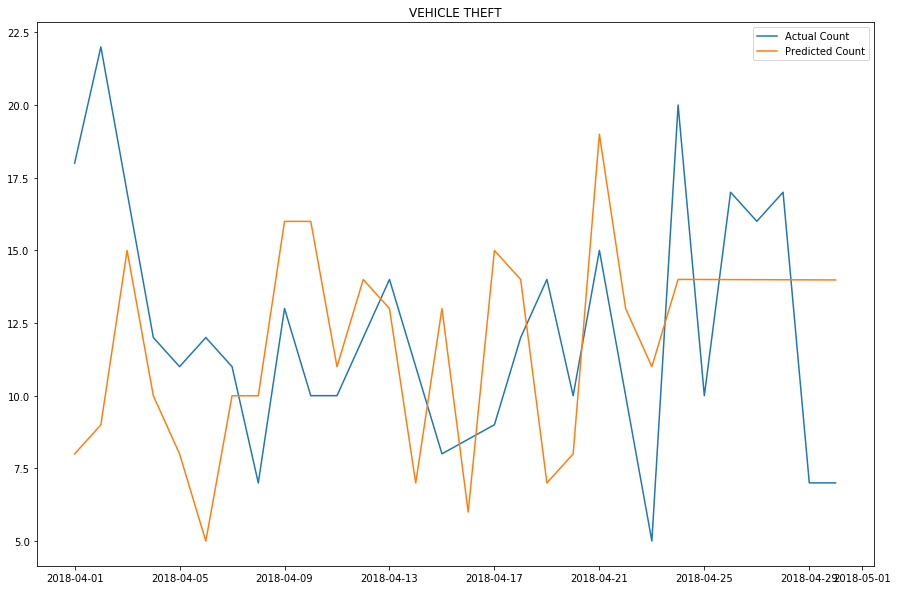

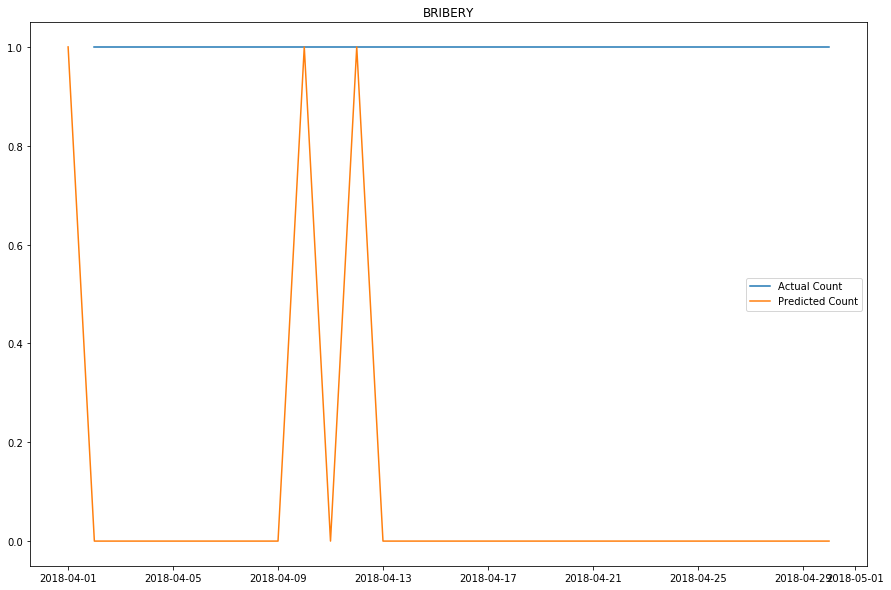

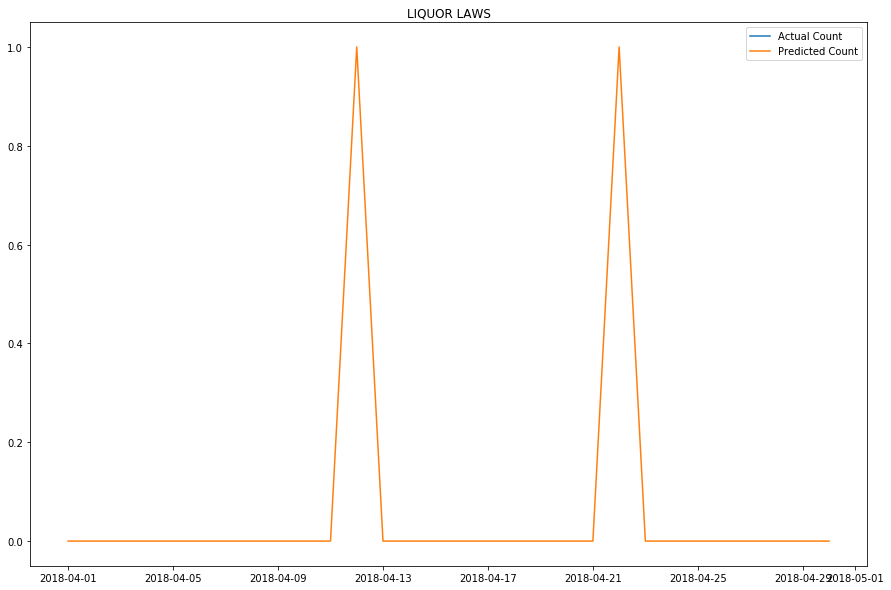

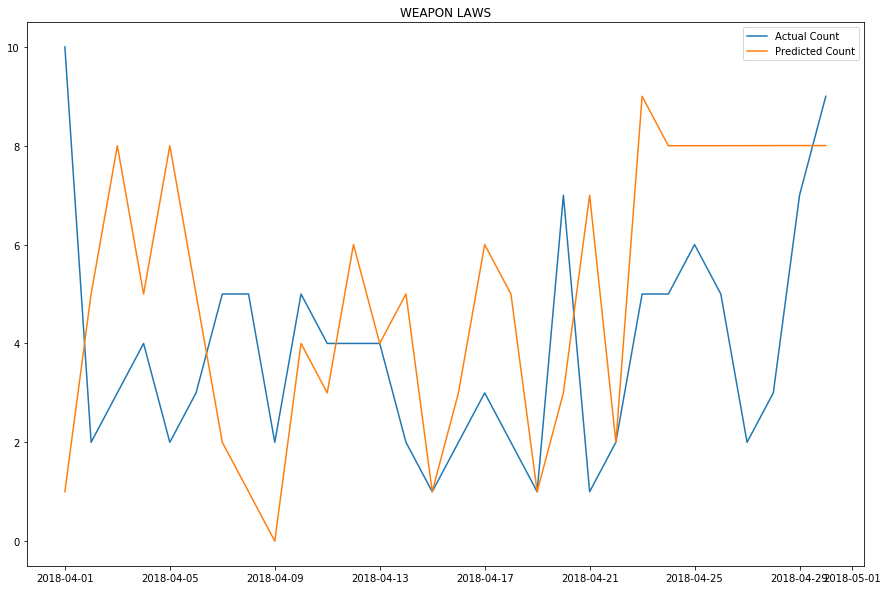

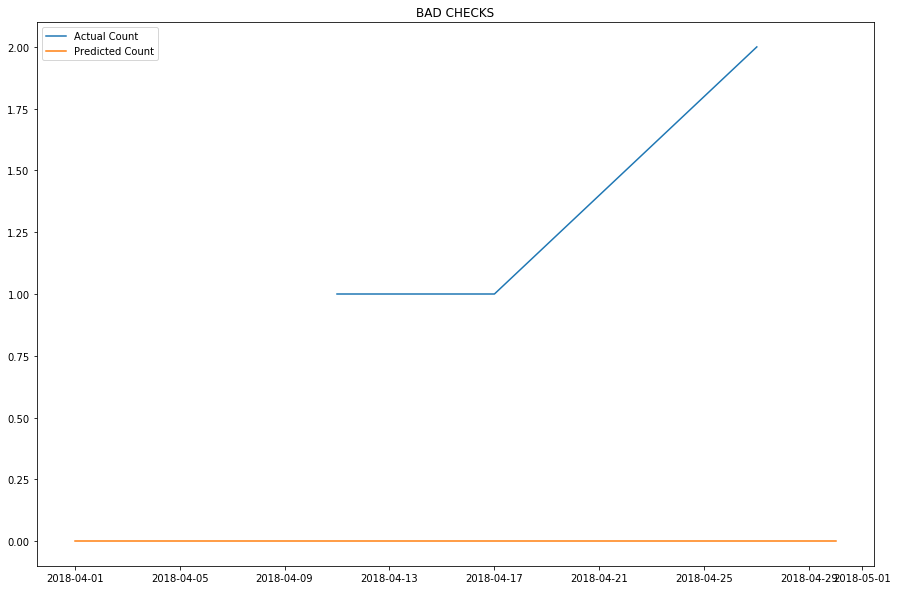

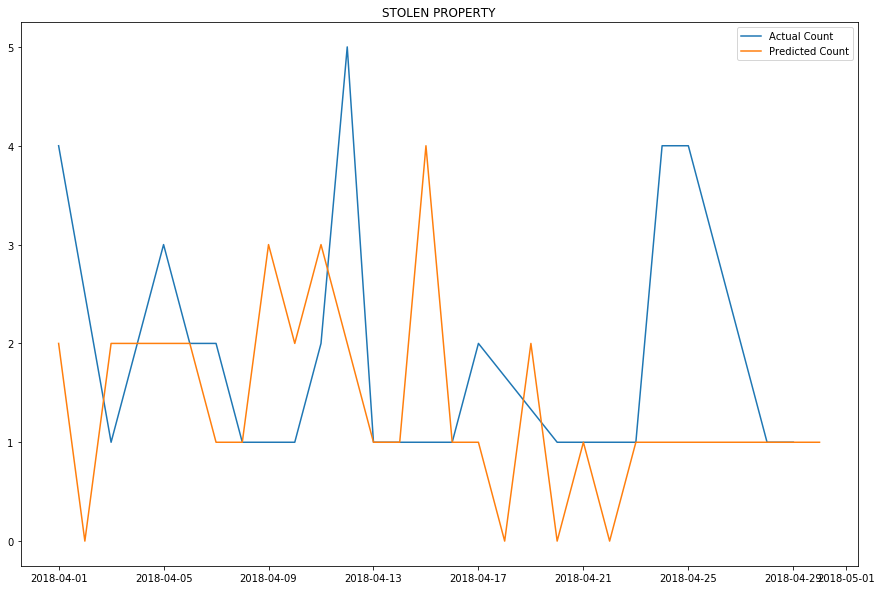

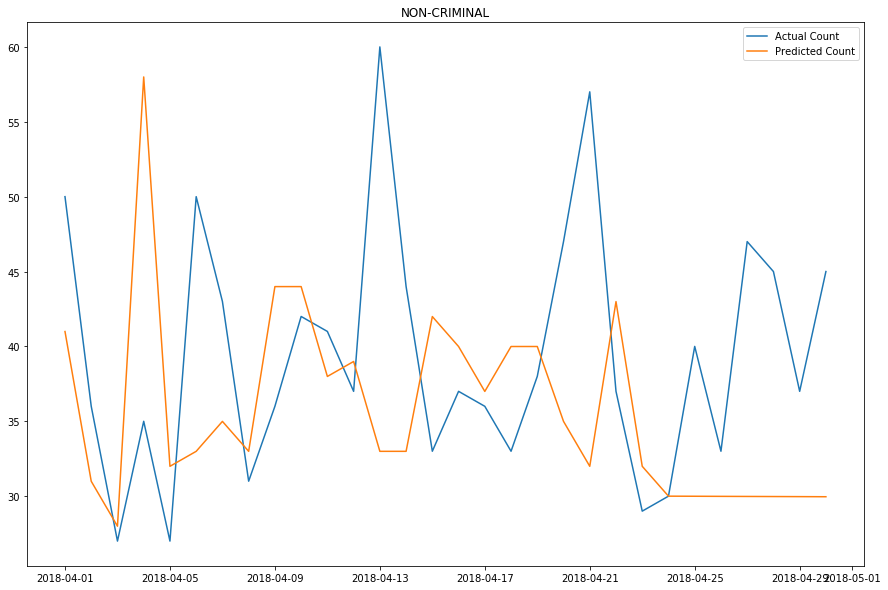

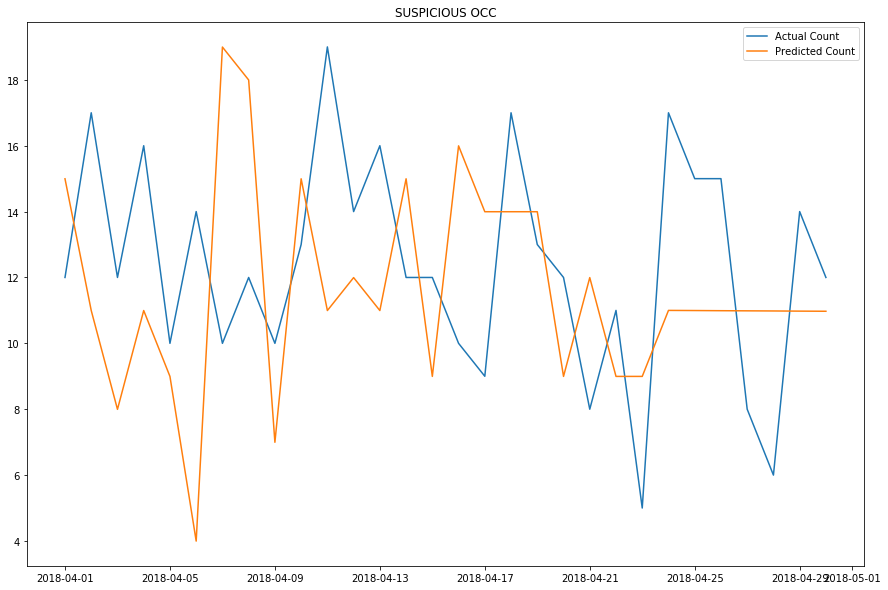

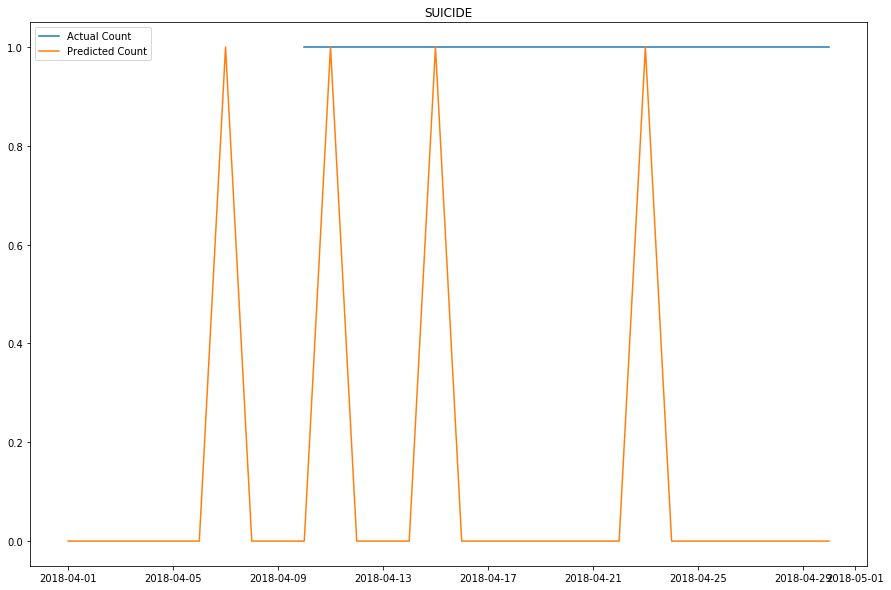

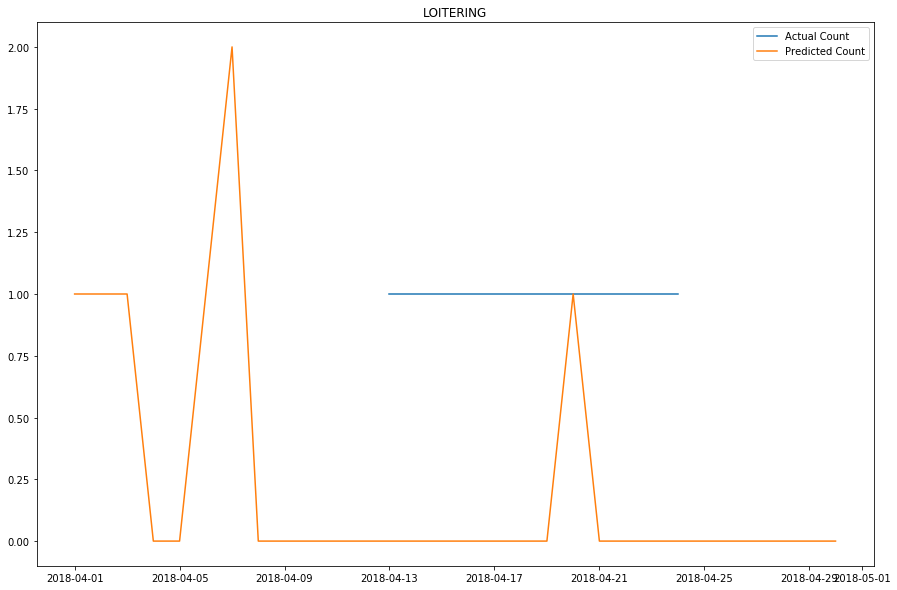

In [134]:
for entry in ts_list:
    label = entry[0]

    arimaModel = ARIMA.fit_model(p=0, d=1, q=0, ts=entry[1], sc=sc)
    prediction = arimaModel.forecast(entry[1], 7)
    fut = Vectors.dense(np.around(np.clip(a=prediction.toArray()[len(prediction.toArray()) - (30 + 1) : len(prediction.toArray()) - 1], a_min=0.000, a_max=None), decimals=3))
    
    dates = crime_date_count_sample_future.where(crime_date_count_sample_future.Category == label).select("Date").collect()    
    realcount = crime_date_count_sample_future.where(crime_date_count_sample_future.Category == label).select("Count").collect()
    
    dates = [r.Date for r in dates]
    realcount = [r.Count for r in realcount]
    
    if (len(dates) == 0):
        dates = date_list
        realcount = np.zeros(30)
    
    plt.figure(figsize=[15,10])
    
    #print(dates)
    plt.title(label)
    plt.plot(dates, realcount, label='Actual Count')
    plt.plot(date_list, fut, label='Predicted Count')
    
    plt.legend()
    
    plt.show()